In [ ]:
! pip install moexalgo
! pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=d06ab5f7a1e79e8a5053e3649b225ad9b562817c9f5f959ed67548a9aa8c92c2
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from moexalgo import Ticker, Market
from tqdm import tqdm
import math
from datetime import datetime, timedelta, timezone

import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# **Test moexalgo**

In [ ]:
sber = Ticker('SBER')

# получим дневные свечи с 2020 года
sber_data = sber.candles(date='2020-01-01', till_date='2023-12-01', period='D',  limit=1000000)

In [ ]:
sber_data

open   close    high     low         value      volume      begin  \
0    255.99  255.00  258.19  253.70  9.165475e+09  35851840.0 2020-01-03   
1    254.75  253.90  254.84  251.40  5.646010e+09  22348300.0 2020-01-06   
2    253.57  259.15  259.15  253.03  1.048588e+10  40817240.0 2020-01-08   
3    259.40  257.99  261.76  257.01  9.936032e+09  38329020.0 2020-01-09   
4    257.86  258.19  259.25  256.88  4.864405e+09  18851390.0 2020-01-10   
..      ...     ...     ...     ...           ...         ...        ...   
968  287.40  282.33  289.00  278.88  2.247182e+10  79146090.0 2023-11-27   
969  282.40  279.91  282.51  277.32  1.272361e+10  45507410.0 2023-11-28   
970  279.36  276.80  280.56  276.20  8.285652e+09  29820830.0 2023-11-29   
971  276.70  277.50  278.65  272.75  1.539141e+10  55873540.0 2023-11-30   
972  277.00  273.97  277.98  273.55  8.726777e+09  31660970.0 2023-12-01   

                    end  
0   2020-01-03 23:59:59  
1   2020-01-06 23:59:59  
2   2020-01-08 23:59:59  
3   2020-01-09 23:59:59  
4   2020-01-10 23:59:59  
..                  ...  
968 2023-11-27 23:59:59  
969 2023-11-28 23:59:59  
970 2023-11-29 23:59:59  
971 2023-11-30 23:59:59  
972 2023-12-01 23:59:59  

[973 rows x 8 columns]

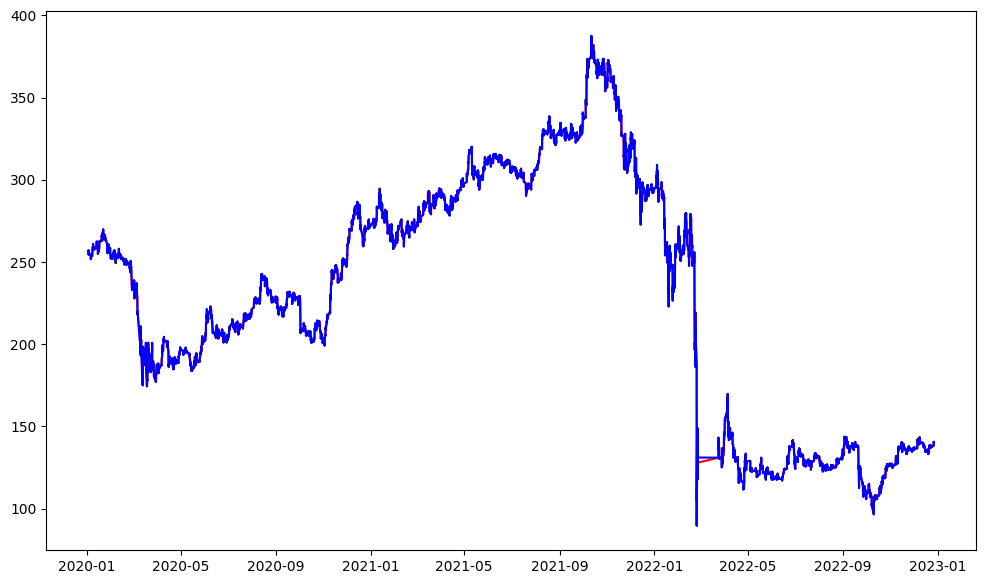

In [ ]:
plt.figure(figsize=(12, 7))
x = sber_data.begin
y = sber_data.open
plt.plot(x, y, color='red')
y = sber_data.close
plt.plot(x, y, color='blue')

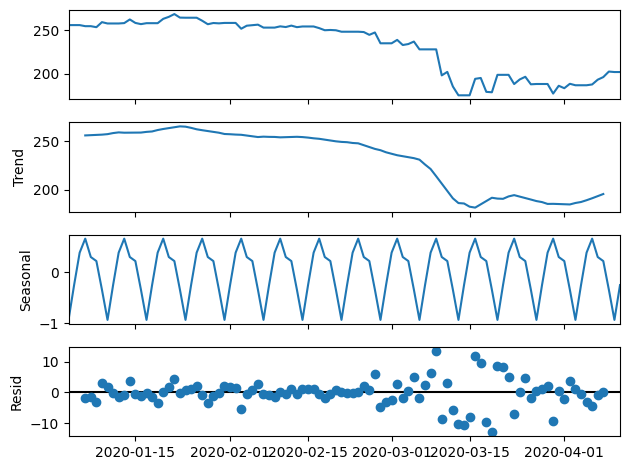

<Figure size 2000x700 with 0 Axes>

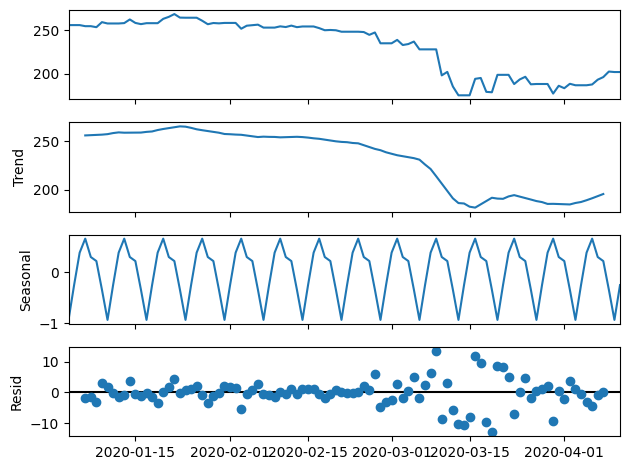

In [ ]:

sber = Ticker('SBER')

# получим дневные свечи с 2020 года
sber_data = sber.candles(date='2020-01-01', till_date='2023-12-01', period='D',  limit=1000000)

data = sber_data.loc[:, ['open', 'begin']]
data = data.set_index('begin').asfreq('D')
data = data.assign(open=data.open.ffill())
decompose = seasonal_decompose(data[:100], model='ad')
plt.figure(figsize=(20, 7))
decompose.plot()

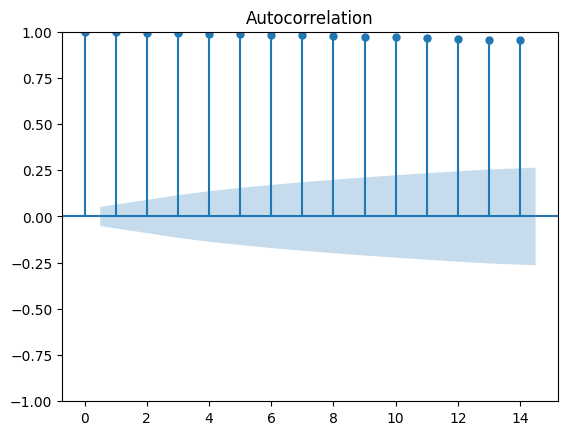

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# применим функцию к нашему набору данных
plot_acf(data.open, lags=14)
plt.show()

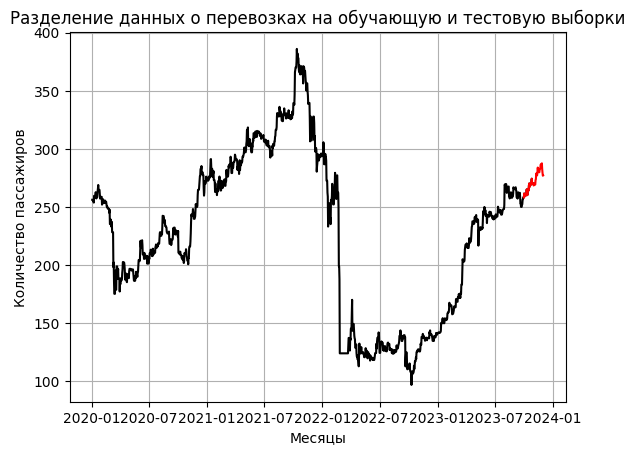

In [ ]:
# обучающая выборка будет включать данные до декабря 1959 года включительно
train = data[:'2023-10']

# тестовая выборка начнется с января 1960 года (по сути, один год)
test = data['2023-10':]



plt.plot(train, color = "black")
plt.plot(test, color = "red")

# заголовок и подписи к осям
plt.title('Разделение данных о перевозках на обучающую и тестовую выборки')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.4 MB/s eta 0:00:00


In [ ]:
# импортируем функцию для автоматического подбора параметров модели ARIMA
from pmdarima import auto_arima


# "погасим" предупреждения
import warnings
warnings.filterwarnings("ignore")

# настроим поиск параметров на обучающей выборке
parameter_search = auto_arima(train, start_p = 1, start_q = 1, max_p = 3, max_q = 3, m = 12, start_P = 0, seasonal = True,
                         d = None, D = 1, trace = True, error_action ='ignore', suppress_warnings = True,  stepwise = True)           #

# выведем результат
print(parameter_search.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=33.91 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=12019.389, Time=0.58 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=8828.221, Time=10.56 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=10688.349, Time=6.25 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=12017.441, Time=0.58 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=9217.220, Time=1.26 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=8647.423, Time=9.57 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=22.21 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=12.81 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=12019.559, Time=6.69 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=8649.392, Time=14.62 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=8649.390, Time=13.98 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=10688.299, Time=8.20 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=8647.933, Time=25.27 sec
 ARIMA(1,0,0)(2,1,0)[1

In [ ]:
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)

from statsmodels.tsa.statespace.sarimax import SARIMAX

# создадим объект этой модели
model = SARIMAX(train,
                order = (1, 0, 0),
                seasonal_order = (2, 1, 0, 12))

# применим метод fit
result = model.fit()

In [ ]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(train)

# и закончится в конце тестового
end = len(train) + len(test) - 1

# применим метод predict
predictions = result.predict(start, end)
predictions

2023-11-01    270.185215
2023-11-02    272.391645
2023-11-03    272.802991
2023-11-04    273.191663
2023-11-05    271.696653
                 ...    
2023-12-28    279.531935
2023-12-29    279.650268
2023-12-30    278.363306
2023-12-31    278.632797
2024-01-01    279.916378
Freq: D, Name: predicted_mean, Length: 62, dtype: float64

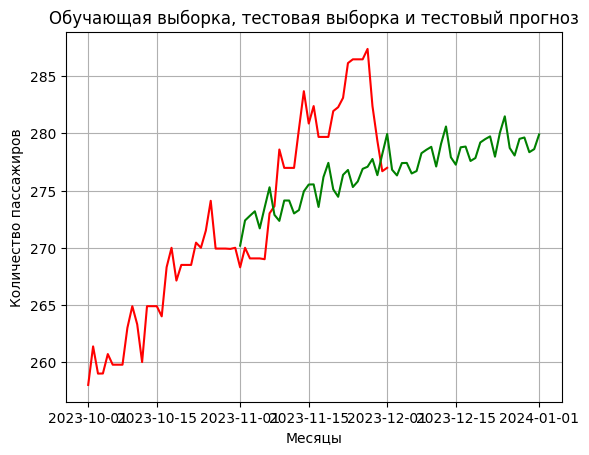

In [ ]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
# plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(predictions, color = "green")

# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()

# **4 try**

In [ ]:
now = datetime.now(timezone(timedelta(hours=3)))
now = now.replace(minute=0, second=0, microsecond=0) - timedelta(hours=1)
now = now.replace(tzinfo=None)

ticket = Ticker('ABIO')
start = datetime(2020, 1, 1, 0, 0, 0)
data = ticket.candles(date=start, till_date=now, period='1h')
data_now = data
while start < now and len(data_now):
    print(start)
    start = data.iloc[-1].begin + timedelta(hours=1)
    data_now = ticket.candles(date=start, till_date=now, period='1h')
    data = pd.concat([data, data_now])
data

2020-01-01 00:00:00


open  close   high    low      value   volume               begin  \
0     13.37  13.04  13.37  12.96     6568.0    500.0 2020-01-03 10:00:00   
1     13.03  13.03  13.03  13.03     1303.0    100.0 2020-01-03 11:00:00   
2     13.00  13.00  13.00  13.00    24700.0   1900.0 2020-01-03 12:00:00   
3     13.25  13.20  13.25  13.20     7925.0    600.0 2020-01-03 13:00:00   
4     13.20  13.20  13.20  13.20     3960.0    300.0 2020-01-03 14:00:00   
...     ...    ...    ...    ...        ...      ...                 ...   
9403  88.16  88.64  88.70  88.10   745749.2   8440.0 2023-12-08 14:00:00   
9404  88.64  86.78  88.64  86.22  5979310.0  68680.0 2023-12-08 15:00:00   
9405  86.36  86.40  87.04  85.00  4172613.2  48690.0 2023-12-08 16:00:00   
9406  86.40  87.24  87.38  86.40  1236709.6  14210.0 2023-12-08 17:00:00   
9407  87.24  87.50  87.60  86.22  1709741.8  19640.0 2023-12-08 18:00:00   

                     end  
0    2020-01-03 10:33:05  
1    2020-01-03 11:25:14  
2    2020-01-03 12:38:26  
3    2020-01-03 13:11:27  
4    2020-01-03 14:03:35  
...                  ...  
9403 2023-12-08 14:59:59  
9404 2023-12-08 15:59:59  
9405 2023-12-08 16:56:08  
9406 2023-12-08 17:59:08  
9407 2023-12-08 18:46:13  

[9408 rows x 8 columns]

In [ ]:
from datetime import datetime

# Строковая дата
date_string = "2020-01-03 10:00:00"

# Преобразуйте строку в объект datetime
date_object = datetime.strptime(date_string, "%Y-%m-%d %H:%M:%S")

print(date_object - timedelta(days=30))

2019-12-04 10:00:00


In [ ]:
def indicator_rsi(min_lvl=30, max_lvl=70, lenght=14):
    rsi = self.data.ta.rsi(length=lenght).to_list()
    for i in range(len(self.data)):
        if math.isnan(rsi[i]):
            rsi[i] = 0
        elif rsi[i] >= max_lvl:
            rsi[i] = 1
        elif rsi[i] <= min_lvl:
            rsi[i] = 2
        else:
            rsi[i] = 0
    return rsi

def indicator_alligator(lenght=[13, 8, 5], offset=[8, 5, 3]):
    jaw = self.data.ta.sma(length=lenght[0], offset=offset[0])
    teeth = self.data.ta.sma(length=lenght[1], offset=offset[1])
    lips = self.data.ta.sma(length=lenght[2], offset=offset[2])
    indicator = []
    for i in range(len(self.data)):
        if math.isnan(jaw[i]) or math.isnan(teeth[i]) or math.isnan(lips[i]):
            indicator.append(0) # Нет достаточных данных для расчета
        elif lips[i] > teeth[i] and teeth[i] > jaw[i]:
            indicator.append(2) # Покупка, аллигатор просыпается
        elif lips[i] < teeth[i] and teeth[i] < jaw[i]:
            indicator.append(1) # Продажа, аллигатор засыпает
        else:
            indicator.append(0) # Ничего, аллигатор спит
    return indicator

def rebuild(array_data):
    repeat_val = array_data[0]
    for i in range(len(array_data) - 1):
        if repeat_val == 1:
            if repeat_val == array_data[i + 1]:
                array_data[i + 1] = 0
            else:
                repeat_val = array_data[i + 1]
        elif repeat_val == 2:
            array_data[i] = 0
            if repeat_val == array_data[i + 1]:
                array_data[i + 1] = 0
            elif array_data[i + 1] != repeat_val:
                array_data[i] = 2
                repeat_val = array_data[i + 1]
        elif repeat_val == 0:
            repeat_val = array_data[i + 1]
    return array_data

def trading(self, start, cash=100_000):
    if start.replace(minute=0, second=0, microsecond=0) - timedelta(hours=1) == self.data.iloc[-1].begin:
        return 0
    finish = start.replace(minute=0, second=0, microsecond=0) - timedelta(hours=1)
    start = start - timedelta(days=30)
    data_now = ticket.candles(date=start, till_date=finish, period=period)
    if not len(data_now):
        return 0


        self.data.index = self.data.begin

In [ ]:
class RSIgator:
    def __init__(self, name_ticket, st='2023-09-01 00:00:00', period='1h'):
        self.period = period
        self.commision = 0.0005
        self.ticket = name_ticket
        now = datetime.now(timezone(timedelta(hours=3)))
        now = now.replace(minute=0, second=0, microsecond=0) - timedelta(hours=1)
        now = now.replace(tzinfo=None)
        start = datetime.strptime(st, "%Y-%m-%d %H:%M:%S") - timedelta(days=30)
        # self.data_now =
        ticket = Ticker(name_ticket)
        self.data = ticket.candles(date=start, till_date=now, period=period)
        data_now = self.data
        while start < now and len(data_now):
            start = self.data.iloc[-1].begin + timedelta(hours=1)
            data_now = ticket.candles(date=start, till_date=now, period=period)
            if len(data_now):
                self.data = pd.concat([self.data, data_now])
        self.st = st
        self.data.index = self.data.begin

    def indicator_rsi(self, data, min_lvl=30, max_lvl=70, lenght=14):
        rsi = data.ta.rsi(length=lenght).to_list()
        for i in range(len(data)):
            if math.isnan(rsi[i]):
                rsi[i] = 0
            elif rsi[i] >= max_lvl:
                rsi[i] = 1
            elif rsi[i] <= min_lvl:
                rsi[i] = 2
            else:
                rsi[i] = 0
        return rsi

    def indicator_alligator(self, data, lenght=[13, 8, 5], offset=[8, 5, 3]):
        jaw = data.ta.sma(length=lenght[0], offset=offset[0])
        teeth = data.ta.sma(length=lenght[1], offset=offset[1])
        lips = data.ta.sma(length=lenght[2], offset=offset[2])
        indicator = []
        for i in range(len(data)):
            if math.isnan(jaw[i]) or math.isnan(teeth[i]) or math.isnan(lips[i]):
                indicator.append(0) # Нет достаточных данных для расчета
            # elif (sorted([jaw[i], teeth[i], lips[i]])[2] - sorted([jaw[i], teeth[i], lips[i]])[0]) / sorted([jaw[i], teeth[i], lips[i]])[0] < 0.005:
            #     indicator.append(0)
            elif lips[i] > teeth[i] and teeth[i] > jaw[i]:
                indicator.append(2) # Покупка, аллигатор просыпается
            elif lips[i] < teeth[i] and teeth[i] < jaw[i]:
                indicator.append(1) # Продажа, аллигатор засыпает
            else:
                indicator.append(0) # Ничего, аллигатор спит
        return indicator

    def rebuild(self, array_data):
        repeat_val = array_data[0]
        for i in range(len(array_data) - 1):
            if repeat_val == 1:
                if repeat_val == array_data[i + 1]:
                    array_data[i + 1] = 0
                else:
                    repeat_val = array_data[i + 1]
            elif repeat_val == 2:
                array_data[i] = 0
                if repeat_val == array_data[i + 1]:
                    array_data[i + 1] = 0
                elif array_data[i + 1] != repeat_val:
                    array_data[i] = 2
                    repeat_val = array_data[i + 1]
            elif repeat_val == 0:
                repeat_val = array_data[i + 1]
        return array_data

    def analysis(self, data):
        data['indicator_rsi'] = self.indicator_rsi(data)
        data['indicator_alligator'] = self.indicator_alligator(data)
        data['indicator_rsi'] = self.rebuild(data['indicator_rsi'].values)
        # data['signal'] = self.rebuild([max(data['indicator_alligator'].iloc[i].item(), data['indicator_rsi'].iloc[i].item()) for i in range(len(data))])
        # data['indicator_alligator'] = self.rebuild(self.data['indicator_alligator'].values)
        return data

    def backtest(self, cash=100_000):
        balance = cash
        amount_paper = 0
        last_price = 0
        arr_balance= []
        trades = []
        data = self.analysis(self.data)
        data = data.loc[self.st:].copy()
        data = data.reset_index(drop=True)
        for i in range(len(data)):
            predict = max(data['indicator_alligator'].iloc[i].item(), data['indicator_rsi'].iloc[i].item())
            # predict = data['signal'].iloc[i]
            if predict == 1 and amount_paper != 0:
                balance += amount_paper * data.iloc[i]['close']
                balance -= amount_paper * self.commision * data.iloc[i]['close']
                amount_paper = 0
                trades.append([data.iloc[i].begin,  data.iloc[i]['close'], 0])
            if predict == 2:
                buy = balance // (data.iloc[i]['close'] * (1 + self.commision))
                amount_paper += buy
                balance -= buy * data.iloc[i]['close']
                balance -= buy * self.commision * data.iloc[i]['close']
                if buy > 0:
                    trades.append([data.iloc[i].begin,  data.iloc[i]['close'], 1])
            arr_balance.append(amount_paper * data.iloc[i]["close"] + balance)
        trades = np.array(trades)
        return arr_balance, trades

    def trading(self, start, cash=100_000):
        finish = start.replace(minute=0, second=0, microsecond=0) + timedelta(hours=1)
        start = start - timedelta(days=30)
        ticket = Ticker(self.ticket)
        # print(start, finish)
        data_now = ticket.candles(date=start, till_date=finish, period=self.period)
        # print(start.replace(minute=0, second=0, microsecond=0) - timedelta(hours=1), self.data.iloc[-1].begin)
        if data_now.iloc[-1].begin == self.data.iloc[-1].begin:
            return -1
        # print(data_now)
        # print(data_now.iloc[-1].begin)
        self.data = data_now
        # print(self.data)
        if not len(data_now):
            return -1
        data_now = self.analysis(data_now)
        return max(data_now['indicator_alligator'].iloc[-1].item(), data_now['indicator_rsi'].iloc[-1].item())

    def keep_cash(self, cash=100_000):
        data = self.data.loc[self.st:].copy()
        data = data.reset_index(drop=True)
        data.index = data.begin
        buy = cash / data.iloc[0].close
        start = data.iloc[0].close * buy
        capital = [start]
        for i in range(1, len(data)):
            capital.append(data.iloc[i].close * buy)
        return capital

    def plot(self, cash=100_000):
        data = self.data.loc[self.st:].copy()
        data = data.reset_index(drop=True)
        data.index = data.begin
        capital, trades = self.backtest()

        print(f'Капитал: {np.round(capital[-1], 2):_}')
        print(f'Процент прироста: {np.round(capital[-1] * 100 / cash, 2)}%')
        print(f'Макс. просадка: {np.round((min(capital) - cash) * 100  / cash, 2)}%')
        print(f'Кол-во сделок: {len(trades)}')
        print(f'Кол-во дней: {(data.iloc[-1].begin - data.iloc[0].begin).days}')

        plt.figure(figsize=(40, 10))
        colors = ['red', 'green']
        plt.subplot(211)
        plt.plot(data.index, capital, label='RSIgator')
        return data.index, capital, self.keep_cash(cash)
        plt.plot(data.index, self.keep_cash(cash), label='hold')
        plt.plot(data.index,  [cash for i in range(len(data))], '-.', label='start')
        plt.ylabel('Капитал', fontsize=20)
        plt.legend()
        plt.grid()
        plt.title(f'{str(self.ticket)}', fontsize=20)
        plt.subplot(212)
        plt.plot(data.index, data.close, label='Цена акции')
        plt.scatter(trades[:, 0], trades[:, 1], c=[colors[val] for val in trades[:, 2]], s=20)
        plt.ylabel('Цена акции', fontsize=20)
        plt.legend()
        plt.grid();

    def plot_for_nik(self, cash=100_000):
        data = self.data.loc[self.st:].copy()
        data = data.reset_index(drop=True)
        data.index = data.begin
        capital, trades = self.backtest()

        plt.figure(figsize=(20, 7))
        #alligator
        plt.plot(data.index, data.close, label='RSIgator', color='blue')
        colors = ['blue', 'red', 'green']
        sizes = [0.01, 20, 20]
        plt.scatter(data.index, data.close, c=[colors[i] for i in data['indicator_alligator']], s=[sizes[i] for i in data['indicator_alligator']])
        for i in range(len(data)):
            if data['indicator_alligator'].iloc[i]:
                plt.annotate('all', (data.index[i], data.close.iloc[i]))

        #rsi
        colors = ['blue', 'yellow', 'navy']
        sizes = [0.01, 20, 20]
        plt.scatter(data.index, data.close, c=[colors[i] for i in data['indicator_rsi']], s=[sizes[i] for i in data['indicator_rsi']])
        for i in range(len(data)):
            if data['indicator_rsi'].iloc[i]:
                plt.annotate('rsi', (data.index[i], data.close.iloc[i]), xytext =(data.index[i], data.close.iloc[i] + 0.2))


        colors = ['blue', 'purple', 'grey']
        sizes = [0.01, 20, 20]
        plt.scatter(data.index, data.close,
                    c = [colors[data['indicator_rsi'].iloc[i]] if data['indicator_rsi'].iloc[i] and data['indicator_alligator'].iloc[i] and data['indicator_rsi'].iloc[i] != data['indicator_alligator'].iloc[i] else 'blue' for i in range(len(data))],
                    s=[10 if data['indicator_rsi'].iloc[i] and data['indicator_alligator'].iloc[i] and data['indicator_rsi'].iloc[i] != data['indicator_alligator'].iloc[i] else 0.01 for i in range(len(data))])


# красные точки - 1 у аллигатора,
# зеленые - 2 у аллигатора
# желтые - 1 у RSI,
# синие - 2 у rsi
# фиолетовый - 1 у RSI,  2 у аллигатора
# серые - 2 у RSI,  1 у аллигатора

In [ ]:
period = '1h'
s = RSIgator('SBER', '2022-05-01 00:00:00', period)
cap, tr = s.backtest()
# data = s.analysis()

Капитал: 238_680.09
Процент прироста: 238.68%
Макс. просадка: -2.23%
Кол-во сделок: 442
Кол-во дней: 587


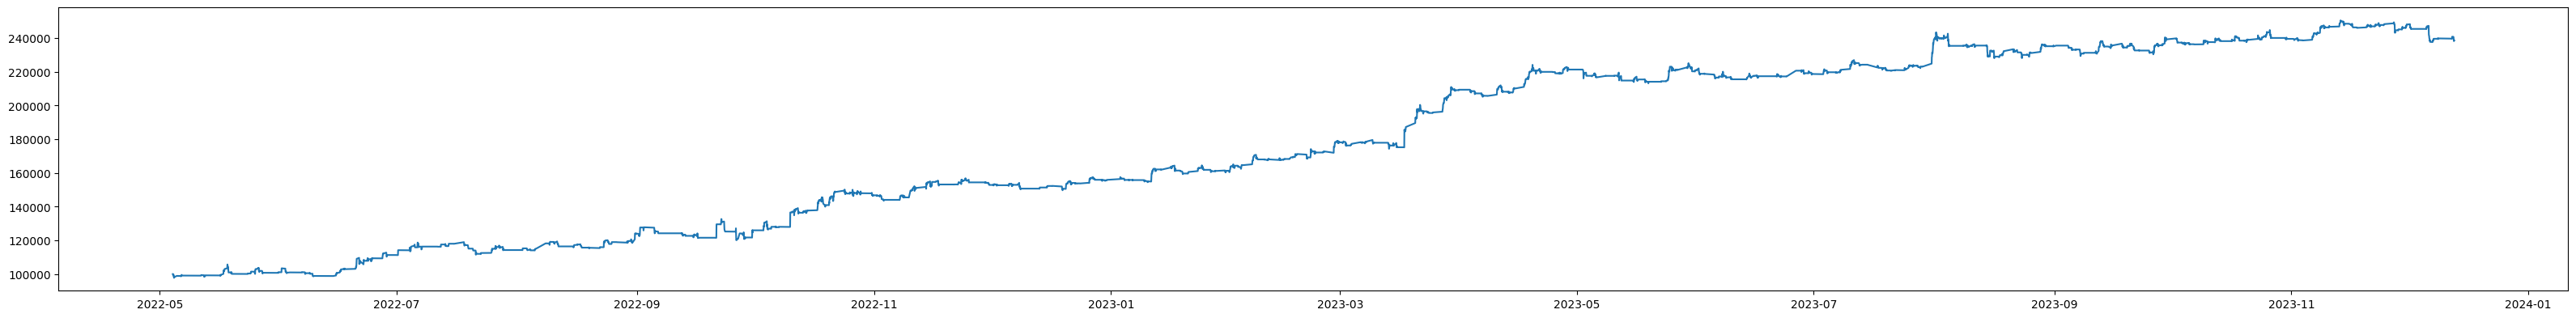

In [ ]:
x, y, k = s.plot()

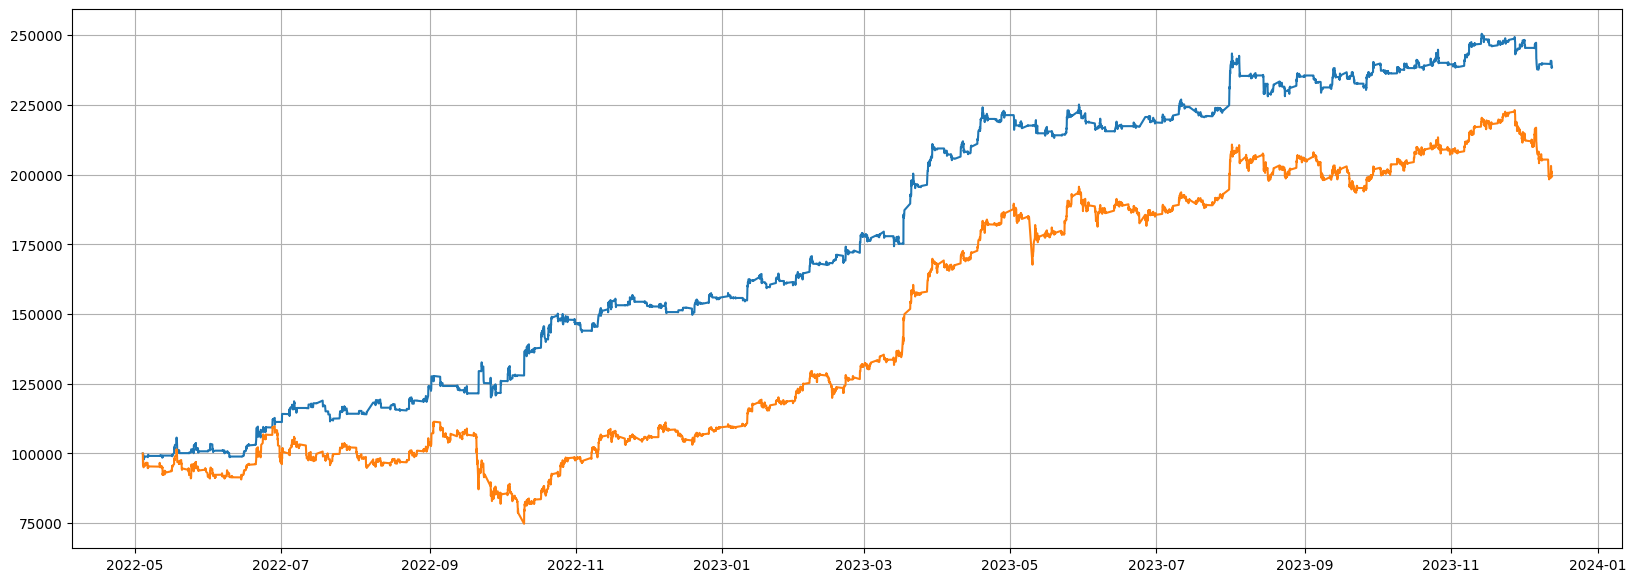

In [ ]:
plt.figure(figsize=(20, 7))
plt.plot(x, y)
plt.plot(x, k)
plt.grid();

Капитал: 238_680.09
Процент прироста: 238.68%
Макс. просадка: -2.23%
Кол-во сделок: 442
Кол-во дней: 587


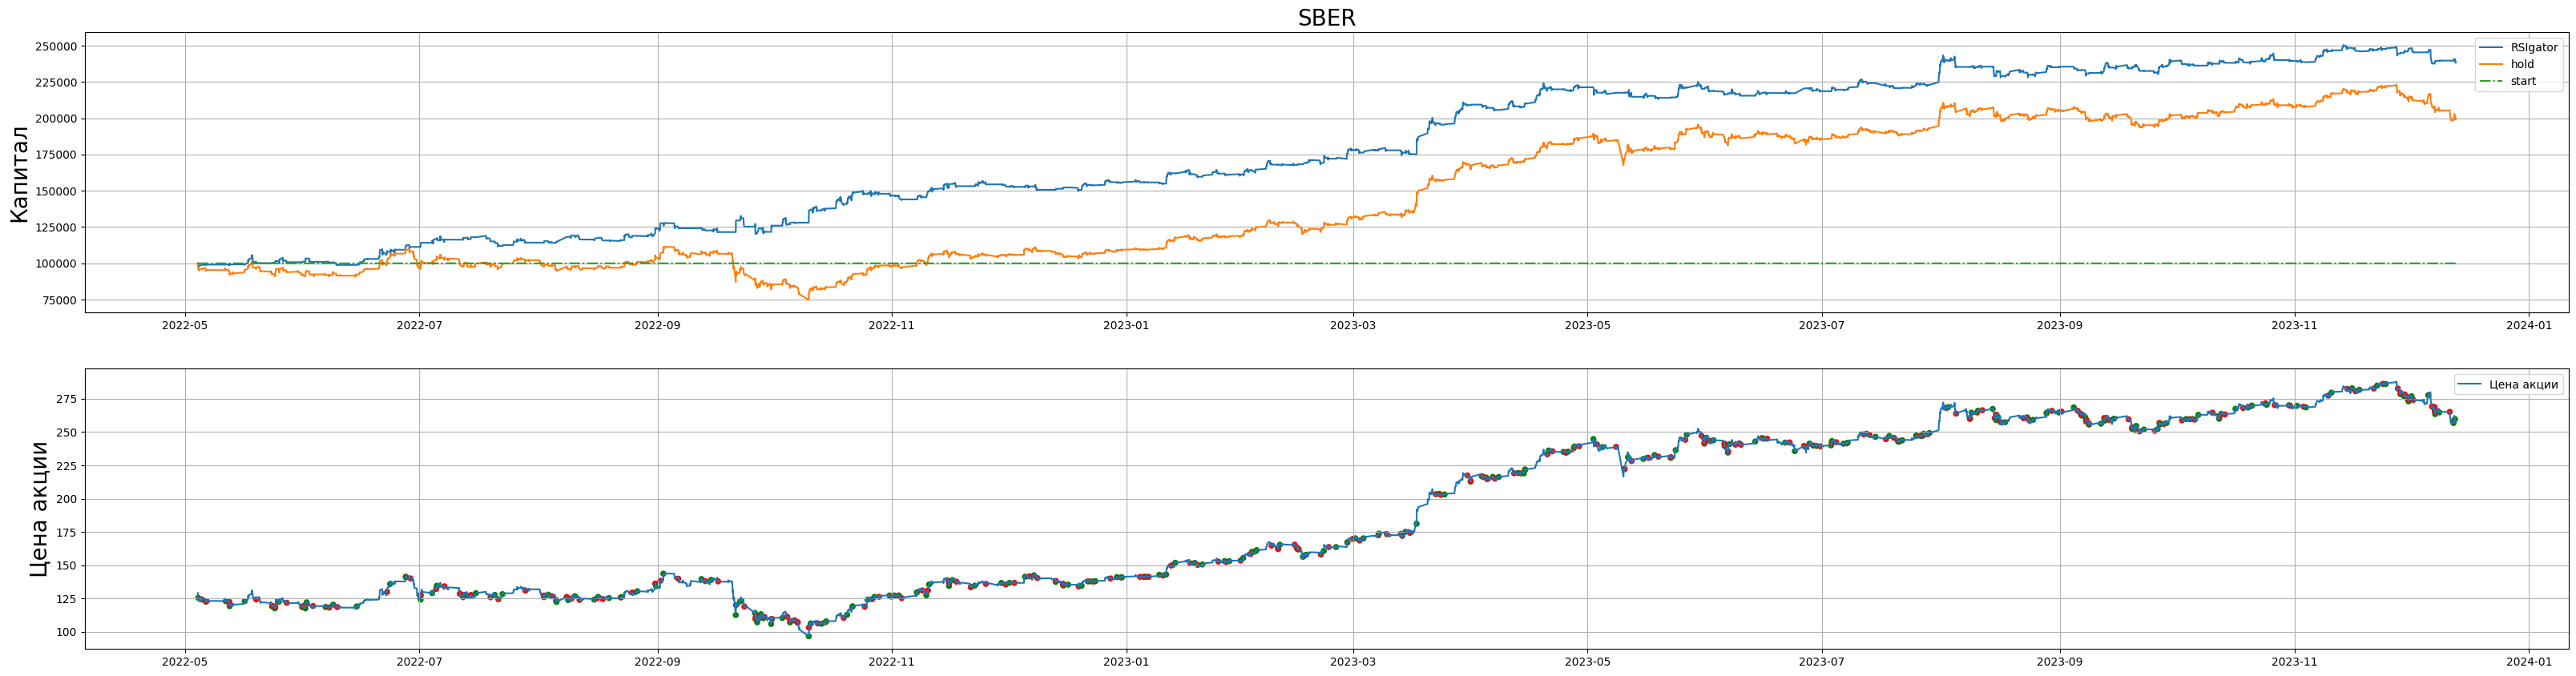

In [ ]:
s.plot()

In [ ]:
  def calculate_sharpe_ratio(returns, risk_free_rate):
    """
    Вычисляет коэффициент Шарпа.

    Параметры:
    returns (numpy.array): Массив доходностей инвестиции.
    risk_free_rate (float): Безрисковая ставка.

    Возвращает:
    float: Коэффициент Шарпа.
    """
    returns = pd.Series(returns).pct_change().fillna(0)
    # Вычислите среднюю доходность сверх безрисковой ставки
    excess_returns = returns - risk_free_rate

    # Вычислите стандартное отклонение доходности
    std_dev = np.std(returns)
    # Вычислите коэффициент Шарпа
    sharpe_ratio = np.sqrt(len(excess_returns))*excess_returns.mean()/excess_returns.std()

    return sharpe_ratio

def calculate_sortino_ratio(returns, mar):
    """
    Функция для расчета коэффициента Сортино.

    Параметры:
    portfolio_returns (list): Список доходностей портфеля.
    mar (float): Минимально допустимый уровень доходности портфеля.

    Возвращает:
    sortino_ratio (float): Коэффициент Сортино.
    """
    # Расчет средней доходности портфеля
    returns = pd.Series(returns).pct_change().fillna(0)
    avg_returns = np.mean(returns)

    # Расчет волатильности вниз
    downside_returns = [ret for ret in returns if ret < 0]
    downside_return = downside_returns[1:]
    downside_std_dev = np.std(downside_returns)

    # Расчет коэффициента Сортино
    sortino_ratio = (avg_returns - mar) / downside_std_dev

    return sortino_ratio

def sharpe_ratio(return_series, N, rf):
    mean = return_series.mean() * N - rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

free_rate = 0.20 / len(s.data)

calculate_sharpe_ratio(cap, free_rate), sharpe_ratio(pd.Series(cap).pct_change().fillna(0), len(s.data), free_rate)


(2.680242040784601, 3.463084430543737)

In [ ]:
stocks = Market('stocks')
data1 = stocks.tradestats(date='2020-01-01')
data2 = stocks.tradestats(date='2023-12-05')
data = pd.concat([data1, data2])
papers = list(data['ticker'].value_counts().index)

In [ ]:
result = pd.DataFrame(columns=['name', 'profit, %', 'hold_profit, %', 'max_risk, %', 'count_trades', 'days', 'sharp_ratio'])
cash = 100_000
st = '2022-05-01 00:00:00'
for ticket in tqdm(papers[:10]):
    s = RSIgator(ticket, st, '1h')
    cap, tr = s.backtest()
    free_rate = 0.20 / len(s.data)
    result.loc[len(result.index)] = [s.ticket, # name
                                     np.round(cap[-1] * 100 / cash, 2), # profit, %
                                     np.round(s.data.loc[st:].iloc[-1].close * 100 / s.data.loc[st:].iloc[0].close, 2), # hold_profit, %
                                     np.round((min(cap) - cash) * 100  / cash, 2), # max_risk, %
                                     len(tr), # count_trades
                                     (s.data.loc[st:].iloc[-1].begin - s.data.loc[st:].iloc[0].begin).days, # days
                                     calculate_sharpe_ratio(cap, free_rate)] # sharp ratio

100%|██████████| 10/10 [08:47<00:00, 52.75s/it]


In [ ]:
result

name  profit, %  hold_profit, %  max_risk, %  count_trades  days  \
0  ABIO     204.22          118.18        -0.62           331   583   
1  OZON     452.14          261.42        -0.05           451   583   
2  ABRD     149.07          135.42        -6.00           291   583   
3  NLMK     252.90          103.93        -1.82           460   583   
4  NMTP     247.65          180.32        -2.44           327   583   
5  NVTK     237.70          147.68        -1.96           459   583   
6  OGKB     243.96          135.44        -0.20           376   583   
7  OKEY     200.80          113.10        -1.73           305   583   
8  PHOR     185.18           94.42        -0.05           458   583   
9  MTSS     197.07          120.43        -0.24           456   583   

   sharp_ratio  
0     1.251287  
1     3.040334  
2     0.702964  
3     2.656135  
4     1.662380  
5     2.498864  
6     2.144242  
7     1.157884  
8     1.710096  
9     1.747032

In [ ]:
ticket = Ticker('NVTK')
data = ticket.candles(date='2020-01-01', till_date='2023-12-01', period='1h')
print(f'strat: {data.begin.min()}\
        \nend: {data.begin.max()}\
        \ncount: {data.shape[0]}')
ST = data.begin[data.begin.argmax()]
# data.drop(['open', 'high', 'low', 'value', 'volume', 'begin', 'end'], axis=1, inplace=True)
data.head()

strat: 2020-01-03 09:00:00        
end: 2022-12-26 20:00:00        
count: 10000


open   close    high     low       value   volume               begin  \
0  1264.2  1264.2  1264.2  1264.2    165610.2    131.0 2020-01-03 09:00:00   
1  1265.0  1264.8  1269.8  1260.6  67881104.6  53628.0 2020-01-03 10:00:00   
2  1264.8  1268.8  1269.0  1264.6  67459339.6  53236.0 2020-01-03 11:00:00   
3  1268.8  1268.4  1270.8  1267.0  45100689.2  35552.0 2020-01-03 12:00:00   
4  1268.4  1269.8  1271.0  1268.0  40617263.2  31983.0 2020-01-03 13:00:00   

                  end  
0 2020-01-03 09:59:59  
1 2020-01-03 10:59:59  
2 2020-01-03 11:59:59  
3 2020-01-03 12:59:59  
4 2020-01-03 13:59:59

In [ ]:
data.index = data.begin
data.head()

open   close    high     low       value   volume  \
begin                                                                      
2020-01-03 09:00:00  1264.2  1264.2  1264.2  1264.2    165610.2    131.0   
2020-01-03 10:00:00  1265.0  1264.8  1269.8  1260.6  67881104.6  53628.0   
2020-01-03 11:00:00  1264.8  1268.8  1269.0  1264.6  67459339.6  53236.0   
2020-01-03 12:00:00  1268.8  1268.4  1270.8  1267.0  45100689.2  35552.0   
2020-01-03 13:00:00  1268.4  1269.8  1271.0  1268.0  40617263.2  31983.0   

                                  begin                 end  
begin                                                        
2020-01-03 09:00:00 2020-01-03 09:00:00 2020-01-03 09:59:59  
2020-01-03 10:00:00 2020-01-03 10:00:00 2020-01-03 10:59:59  
2020-01-03 11:00:00 2020-01-03 11:00:00 2020-01-03 11:59:59  
2020-01-03 12:00:00 2020-01-03 12:00:00 2020-01-03 12:59:59  
2020-01-03 13:00:00 2020-01-03 13:00:00 2020-01-03 13:59:59

In [ ]:
def indicator_rsi(data, min_lvl=30, max_lvl=70, lenght=14):
    rsi = data.ta.rsi(length=lenght)
    print(type(min_lvl))
    for i in range(len(data)):
        if math.isnan(rsi[i]):
            rsi[i] = 0
        elif rsi[i] >= max_lvl:
            rsi[i] = 1
        elif rsi[i] <= min_lvl:
            rsi[i] = 2
        else:
            rsi[i] = 0
    return rsi

data['indicator_rsi'] = indicator_rsi(data)

<class 'int'>


In [ ]:
rsi = indicator_rsi(data)
repeat_val = rsi[0]
for i in range(len(rsi) - 1):
    if repeat_val == 1:
        if repeat_val == rsi[i + 1]:
            rsi[i + 1] = 0
        else:
            repeat_val = rsi[i + 1]
    elif repeat_val == 2:
        rsi[i] = 0
        if repeat_val == rsi[i + 1]:
            rsi[i + 1] = 0
        elif rsi[i + 1] != repeat_val:
            rsi[i] = 2
            repeat_val = rsi[i + 1]
    elif repeat_val == 0:
        repeat_val = rsi[i + 1]

data['indicator_rsi'] = rsi

<class 'int'>


In [ ]:
data

open   close    high     low        value    volume  \
begin                                                                        
2020-01-03 09:00:00  1264.2  1264.2  1264.2  1264.2     165610.2     131.0   
2020-01-03 10:00:00  1265.0  1264.8  1269.8  1260.6   67881104.6   53628.0   
2020-01-03 11:00:00  1264.8  1268.8  1269.0  1264.6   67459339.6   53236.0   
2020-01-03 12:00:00  1268.8  1268.4  1270.8  1267.0   45100689.2   35552.0   
2020-01-03 13:00:00  1268.4  1269.8  1271.0  1268.0   40617263.2   31983.0   
...                     ...     ...     ...     ...          ...       ...   
2022-12-26 16:00:00  1051.8  1054.0  1058.2  1051.2   79970872.8   75784.0   
2022-12-26 17:00:00  1054.6  1047.8  1055.0  1047.4  116421415.6  110914.0   
2022-12-26 18:00:00  1047.8  1052.0  1052.2  1047.0   54554279.0   52024.0   
2022-12-26 19:00:00  1052.0  1051.8  1053.2  1050.0    9063873.2    8618.0   
2022-12-26 20:00:00  1052.0  1052.4  1052.8  1051.2    4926577.2    4683.0   

                                  begin                 end  indicator_rsi  
begin                                                                       
2020-01-03 09:00:00 2020-01-03 09:00:00 2020-01-03 09:59:59            0.0  
2020-01-03 10:00:00 2020-01-03 10:00:00 2020-01-03 10:59:59            0.0  
2020-01-03 11:00:00 2020-01-03 11:00:00 2020-01-03 11:59:59            0.0  
2020-01-03 12:00:00 2020-01-03 12:00:00 2020-01-03 12:59:59            0.0  
2020-01-03 13:00:00 2020-01-03 13:00:00 2020-01-03 13:59:59            0.0  
...                                 ...                 ...            ...  
2022-12-26 16:00:00 2022-12-26 16:00:00 2022-12-26 16:59:59            0.0  
2022-12-26 17:00:00 2022-12-26 17:00:00 2022-12-26 17:59:59            0.0  
2022-12-26 18:00:00 2022-12-26 18:00:00 2022-12-26 18:59:59            0.0  
2022-12-26 19:00:00 2022-12-26 19:00:00 2022-12-26 19:59:59            0.0  
2022-12-26 20:00:00 2022-12-26 20:00:00 2022-12-26 20:59:59            0.0  

[10000 rows x 9 columns]

<Axes: xlabel='indicator_rsi', ylabel='count'>

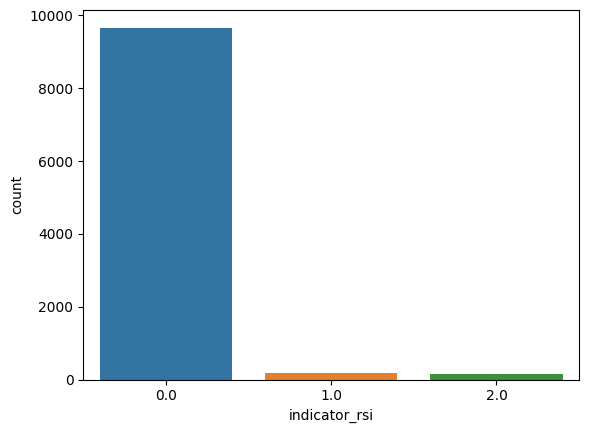

In [ ]:
sns.countplot(x = data.indicator_rsi)

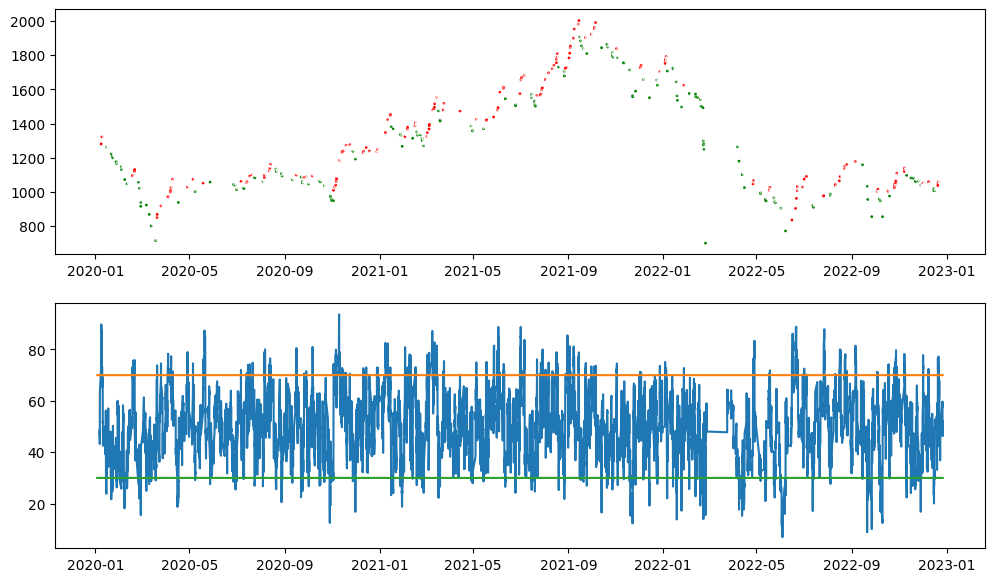

In [ ]:
colors = ['white', 'red', 'green']
s = [0.01, 1, 1]
plt.figure(figsize=(12, 7))
plt.subplot(211)
plt.scatter(data.index, data.close, c=[colors[int(i)] for i in data.indicator_rsi], s=[s[int(i)] for i in data.indicator_rsi])
plt.subplot(212)
plt.plot(data.ta.rsi(lenght=14))
plt.plot(data.index, [70 for i in range(len(data))])
plt.plot(data.index, [30 for i in range(len(data))])

In [ ]:
def indicator_alligator(data, lenght=[13, 8, 5], offset=[8, 5, 3]):
    jaw = data.ta.sma(length=lenght[0], offset=offset[0])
    teeth = data.ta.sma(length=lenght[1], offset=offset[1])
    lips = data.ta.sma(length=lenght[2], offset=offset[2])
    indicator = []
    for i in range(len(data)):
        if math.isnan(jaw[i]) or math.isnan(teeth[i]) or math.isnan(lips[i]):
            indicator.append(0) # Нет достаточных данных для расчета
        elif lips[i] > teeth[i] and teeth[i] > jaw[i]:
            indicator.append(2) # Покупка, аллигатор просыпается
        elif lips[i] < teeth[i] and teeth[i] < jaw[i]:
            indicator.append(1) # Продажа, аллигатор засыпает
        else:
            indicator.append(0) # Ничего, аллигатор спит
    return indicator

alligator = indicator_alligator(data)
repeat_val = rsi[0]
for i in range(len(rsi) - 1):
    if repeat_val == 1:
        if repeat_val == rsi[i + 1]:
            rsi[i + 1] = 0
        else:
            repeat_val = rsi[i + 1]
    elif repeat_val == 2:
        rsi[i] = 0
        if repeat_val == rsi[i + 1]:
            rsi[i + 1] = 0
        elif rsi[i + 1] != repeat_val:
            rsi[i] = 2
            repeat_val = rsi[i + 1]
    elif repeat_val == 0:
        repeat_val = rsi[i + 1]

data['indicator_alligator'] = alligator

<Axes: xlabel='indicator_alligator', ylabel='count'>

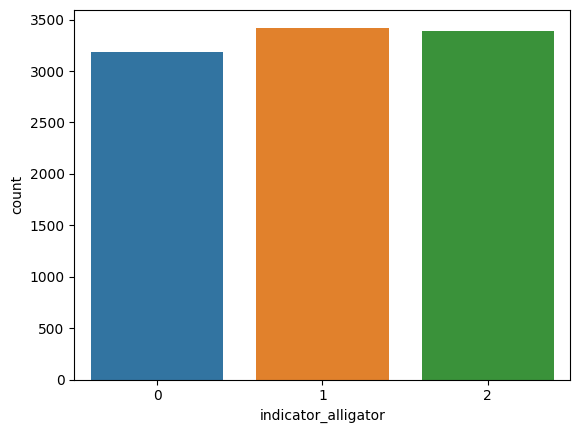

In [ ]:
sns.countplot(x = data.indicator_alligator)

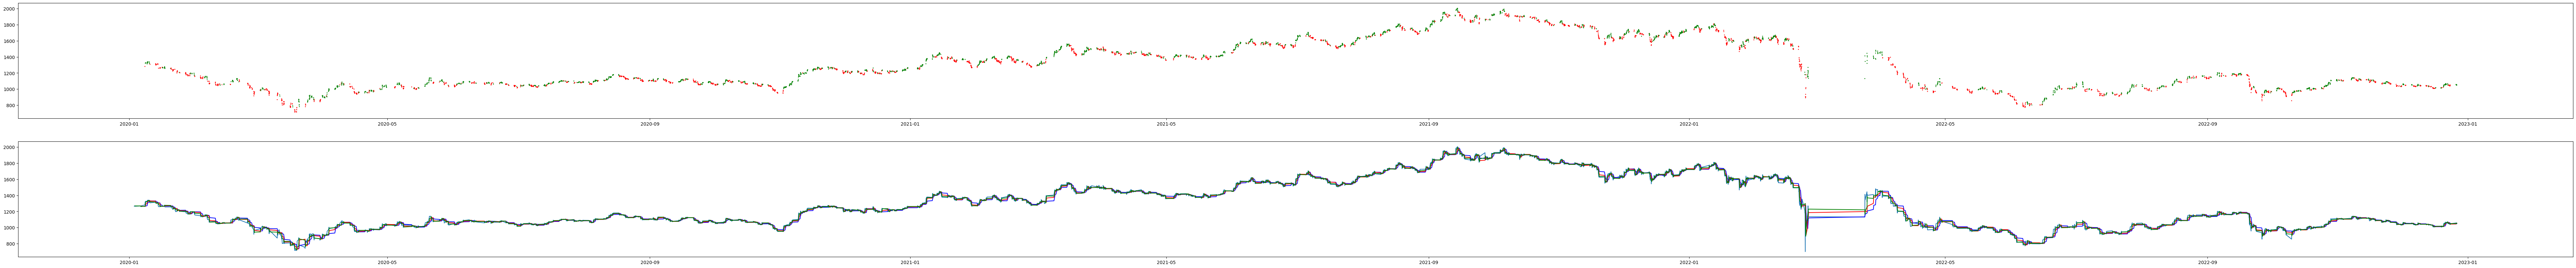

In [ ]:
colors = ['white', 'red', 'green']
s = [0.01, 1, 1]
lenght=[13, 8, 5]
offset=[8, 5, 3]
jaw = data.ta.sma(length=lenght[0], offset=offset[0])
teeth = data.ta.sma(length=lenght[1], offset=offset[1])
lips = data.ta.sma(length=lenght[2], offset=offset[2])

plt.figure(figsize=(100, 10))
plt.subplot(211)
plt.scatter(data.index, data.close, c=[colors[int(i)] for i in indicator_alligator(data)], s=[s[int(i)] for i in indicator_alligator(data)])
plt.subplot(212)
plt.plot(data.index, data.close)
plt.plot(data.index, jaw, color='blue')
plt.plot(data.index, teeth, color='red')
plt.plot(data.index, lips, color='green')

In [ ]:
!pip install backtesting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173916 sha256=52575ae4a21648f09e807883e8ab363d7b4a3fd74978e79564cd1e8caea7a5e2
  Stored in directory: /root/.cache/pip/wheels/e2/30/7f/19cbe31987c6ebdb47f1f510343249066711609e3da2d57176
Successfully built backtesting


In [ ]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA, GOOG

def indicator_rsi(data, min_lvl=30, max_lvl=70, lenght=14):
    rsi = data.ta.rsi(length=lenght).to_list()
    for i in range(len(data)):
        if math.isnan(rsi[i]):
            rsi[i] = 0
        elif rsi[i] >= max_lvl:
            rsi[i] = 1
        elif rsi[i] <= min_lvl:
            rsi[i] = 2
        else:
            rsi[i] = 0
    return pd.Series(rsi)

def indicator_alligator(data, lenght=[13, 8, 5], offset=[8, 5, 3]):
    jaw = data.ta.sma(length=lenght[0], offset=offset[0])
    teeth = data.ta.sma(length=lenght[1], offset=offset[1])
    lips = data.ta.sma(length=lenght[2], offset=offset[2])
    indicator = []
    for i in range(len(data)):
        if math.isnan(jaw[i]) or math.isnan(teeth[i]) or math.isnan(lips[i]):
            indicator.append(0) # Нет достаточных данных для расчета
        elif lips[i] > teeth[i] and teeth[i] > jaw[i]:
            indicator.append(2) # Покупка, аллигатор просыпается
        elif lips[i] < teeth[i] and teeth[i] < jaw[i]:
            indicator.append(1) # Продажа, аллигатор засыпает
        else:
            indicator.append(0) # Ничего, аллигатор спит
    return indicator

def rebuild(array_data):
    repeat_val = array_data[0]
    for i in range(len(array_data) - 1):
        if repeat_val == 1:
            if repeat_val == array_data[i + 1]:
                array_data[i + 1] = 0
            else:
                repeat_val = array_data[i + 1]
        elif repeat_val == 2:
            array_data[i] = 0
            if repeat_val == array_data[i + 1]:
                array_data[i + 1] = 0
            elif array_data[i + 1] != repeat_val:
                array_data[i] = 2
                repeat_val = array_data[i + 1]
        elif repeat_val == 0:
            repeat_val = array_data[i + 1]
    return pd.Series(array_data)

ticket = Ticker('SBER')
data = ticket.candles(date='2023-01-01', till_date='2023-12-01', period='1h')


data['indicator_rsi'] = rebuild(indicator_rsi(data))
data['indicator_alligator'] = indicator_alligator(data)

data.index = data.begin
data.columns = data.columns.str.capitalize()

class SmaCross(Strategy):

    def init(self):
        close = self.data.Close
        self.rsi = self.data.Indicator_rsi
        self.all = self.data.Indicator_alligator
        self.ind = []
        self.last = 1
        for i in range(len(self.rsi)):
            self.ind.append(int(max(self.rsi[i], self.all[i])))
        self.ind = self.I(lambda x: x, np.array(self.ind))

    def next(self):
        if self.ind[-1] == 2 and self.last == 1:
            self.buy(sl=.8 * self.data.Close[-1], tp=1.2 * self.data.Close[-1])
            # self.position.close()
        elif self.ind[-1] == 1 and self.last == 2:
            self.sell(sl=1.2 * self.data.Close[-1], tp=0.8 * self.data.Close[-1])
            # self.position.close()
        self.last = self.ind[-1] if self.ind[-1] else self.last


bt = Backtest(data, SmaCross,
              cash=100_000, commission=.0005, exclusive_orders=True)

output = bt.run()
bt.plot()

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p5290', ...)

In [ ]:
output

Start                     2023-01-03 09:00:00
End                       2023-12-01 23:00:00
Duration                    332 days 14:00:00
Exposure Time [%]                   99.002849
Equity Final [$]                128492.897285
Equity Peak [$]                  131146.50909
Return [%]                          28.492897
Buy & Hold Return [%]               93.481638
Return (Ann.) [%]                   30.994915
Volatility (Ann.) [%]               28.094036
Sharpe Ratio                         1.103256
Sortino Ratio                        2.769742
Calmar Ratio                         2.352344
Max. Drawdown [%]                  -13.176183
Avg. Drawdown [%]                   -1.805816
Max. Drawdown Duration      187 days 08:00:00
Avg. Drawdown Duration        8 days 21:00:00
# Trades                                  260
Win Rate [%]                             45.0
Best Trade [%]                      12.224396
Worst Trade [%]                     -3.981847
Avg. Trade [%]                    

Капитал: 601_440.2
Процент прироста: 601.44
Кол-во сделок: 824
Кол-во дней: 1088


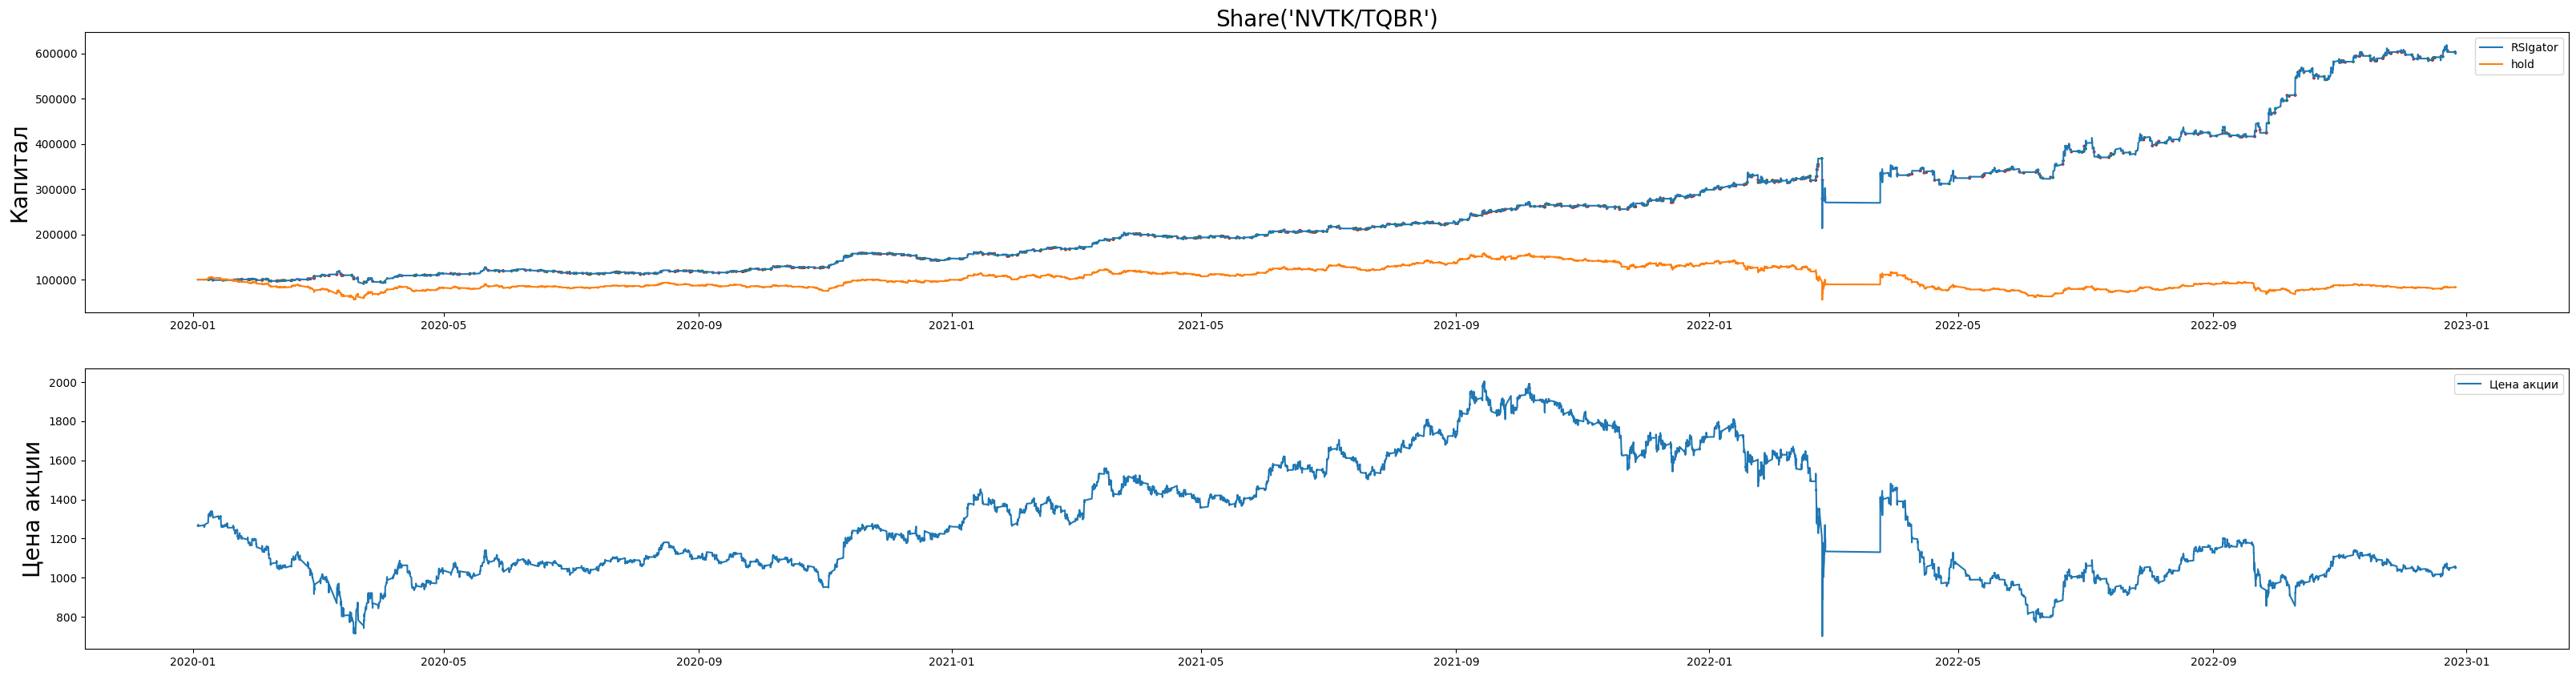

In [ ]:
cash = 100_000
data_slice = data.loc[:]
capital, trades = backtest_3(data_slice, cash)

print(f'Капитал: {np.round(capital[-1], 2):_}')
print(f'Процент прироста: {np.round(capital[-1] * 100 / cash, 2)}')
print(f'Кол-во сделок: {len(trades)}')
print(f'Кол-во дней: {(data_slice.iloc[-1].begin - data_slice.iloc[0].begin).days}')

plt.figure(figsize=(40, 10))
colors = ['red', 'green']
plt.subplot(211)
plt.scatter(trades[:, 0], trades[:, 1], c=[colors[val] for val in trades[:, 2]], s=3)
plt.plot(data_slice.index, capital, label='RSIgator')
plt.plot(data_slice.index, keep_cash(data_slice, cash), label='hold')
plt.ylabel('Капитал', fontsize=20)
plt.legend()
plt.title(f'{str(ticket)}', fontsize=20)
plt.subplot(212)
plt.plot(data_slice.index, data_slice.close, label='Цена акции')
plt.ylabel('Цена акции', fontsize=20)
plt.legend();

# **3 try**

In [ ]:
now = datetime.now(timezone(timedelta(hours=3)))
now = now.replace(minute=0, second=0, microsecond=0) - timedelta(hours=1)
now = now.replace(tzinfo=None)
start = datetime.strptime('2020-01-01 00:00:00', "%Y-%m-%d %H:%M:%S")
ticket = Ticker('SBER')
data = ticket.candles(date=start, till_date=now, period=period)
data_now = data
while start < now and len(data_now):
    start = data.iloc[-1].begin + timedelta(hours=1)
    data_now = ticket.candles(date=start, till_date=now, period=period)
    if len(data_now):
        data = pd.concat([data, data_now])
data.index = data.begin
# data = ticket.candles(date='202-01-01', till_date=now, period='1h')
# print(f'strat: {data.begin.min()}\
#         \nend: {data.begin.max()}\
#         \ncount: {data.shape[0]}')
# ST = data.begin[data.begin.argmax()]
# data.drop(['open', 'high', 'low', 'value', 'volume', 'begin', 'end'], axis=1, inplace=True)
data

open   close    high     low         value     volume  \
begin                                                                          
2020-01-03 09:00:00  255.99  255.99  255.99  255.99  7.085803e+06    27680.0   
2020-01-03 10:00:00  255.97  255.77  256.97  255.52  1.192099e+09  4651320.0   
2020-01-03 11:00:00  255.78  257.01  257.05  255.52  9.630942e+08  3754140.0   
2020-01-03 12:00:00  257.00  257.20  258.19  256.77  1.045291e+09  4061070.0   
2020-01-03 13:00:00  257.20  256.45  257.60  256.06  7.833163e+08  3052930.0   
...                     ...     ...     ...     ...           ...        ...   
2023-12-08 19:00:00  265.23  264.97  265.23  264.54  3.064494e+08  1156710.0   
2023-12-08 20:00:00  264.97  264.92  265.00  264.70  1.300414e+08   490890.0   
2023-12-08 21:00:00  264.94  264.87  265.12  264.68  1.557833e+08   588040.0   
2023-12-08 22:00:00  264.87  265.04  265.40  264.83  1.426249e+08   537910.0   
2023-12-08 23:00:00  265.04  265.16  265.20  264.93  1.226070e+08   462570.0   

                                  begin                 end  
begin                                                        
2020-01-03 09:00:00 2020-01-03 09:00:00 2020-01-03 09:59:59  
2020-01-03 10:00:00 2020-01-03 10:00:00 2020-01-03 10:59:59  
2020-01-03 11:00:00 2020-01-03 11:00:00 2020-01-03 11:59:59  
2020-01-03 12:00:00 2020-01-03 12:00:00 2020-01-03 12:59:59  
2020-01-03 13:00:00 2020-01-03 13:00:00 2020-01-03 13:59:59  
...                                 ...                 ...  
2023-12-08 19:00:00 2023-12-08 19:00:00 2023-12-08 19:59:59  
2023-12-08 20:00:00 2023-12-08 20:00:00 2023-12-08 20:59:59  
2023-12-08 21:00:00 2023-12-08 21:00:00 2023-12-08 21:59:59  
2023-12-08 22:00:00 2023-12-08 22:00:00 2023-12-08 22:59:59  
2023-12-08 23:00:00 2023-12-08 23:00:00 2023-12-08 23:59:54  

[13652 rows x 8 columns]

In [ ]:
data['ATR'] = data.ta.atr(lenght=20)
data['RSI'] = data.ta.rsi()
data['Average'] = data.ta.midprice(length=1)
data['MA40'] = data.ta.sma(length=10)
data['MA80'] = data.ta.sma(length=20)
data['MA160'] = data.ta.sma(length=40)

from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
backrollingN = 5
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
data['slopeMA40'] = data['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
data['slopeMA80'] = data['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
data['slopeMA160'] = data['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
data['AverageSlope'] = data['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
data['RSISlope'] = data['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

In [ ]:
data['next_close'] = data['close'].shift(-1)
data.dropna(inplace=True)

def make_trend(row):
    diff = ((row['close'] - row['next_close'])) / row['close']
    level = 0.01
    if diff > level:
        return 2
    elif diff < -level:
        return 1
    return 0

data['Trend'] = data.apply(lambda x : make_trend(x), axis=1)
data.drop('next_close', axis=1, inplace=True)

In [ ]:
pipdiff = 100 * 0.01#for TP
SLTPRatio = 2 #pipdiff/Ratio gives SL

def trend(barsupfront, df1):
    length = len(df1)
    high = list(df1['high'])
    low = list(df1['low'])
    close = list(df1['close'])
    open = list(df1['open'])
    trendcat = [None] * length

    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend

    return trendcat

# trend(barsfront to take into account, dataframe)
data['Trend'] = trend(1, data)

In [ ]:
def trend_scanner(dataframe, look_ahead_window):
    length = len(dataframe)
    high = list(dataframe['high'])
    low = list(dataframe['low'])
    close = list(dataframe['close'])
    open = list(dataframe['open'])
    category = [None] * length

    y_delta  = 3
    for line in range (0, length-1-look_ahead_window):
        for i in range(1,look_ahead_window+1):
            if( ((high[line+i]-close[line])>y_delta ) and ((close[line]-low[line+i])>y_delta ) ):
                category[line] = 0 # no trend
                break
            elif(close[line]-low[line+i])>y_delta :
                category[line] = 2 #downtrend
                break
            elif ((high[line+i]-close[line])>y_delta ):
                category[line] = 1 # uptrend
                break
            else:
                category[line] = 0 # no clear trend
    return category

data['Trend'] = trend_scanner(data,12)

In [ ]:
data.dropna(inplace=True)

<Axes: ylabel='count'>

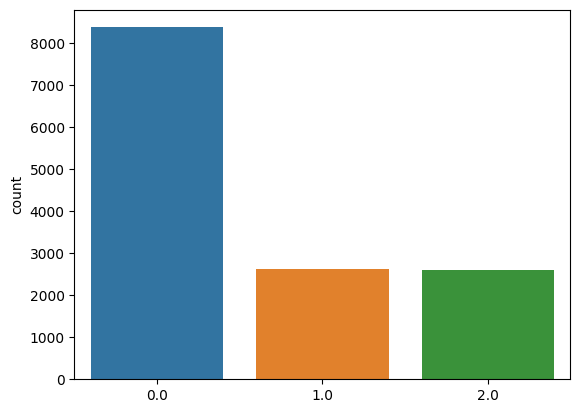

In [ ]:
sns.countplot(x=data['Trend'].values)

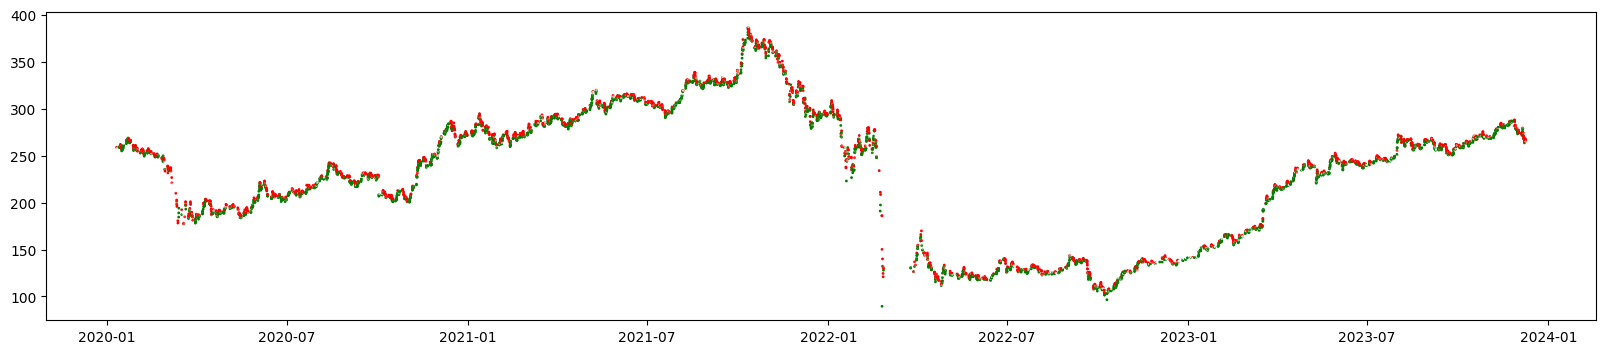

In [ ]:
colors = ['white', 'red', 'green']
s = [0.01,  1, 1]
plt.figure(figsize=(20, 4))
plt.scatter(data.index, data.close, c=[colors[int(i)] for i in data.Trend], s=[s[int(i)] for i in data.Trend])

In [ ]:
def indicator_rsi(data, min_lvl=30, max_lvl=70, lenght=14):
    rsi = data.ta.rsi(length=lenght).to_list()
    for i in range(len(data)):
        if math.isnan(rsi[i]):
            rsi[i] = 0
        elif rsi[i] >= max_lvl:
            rsi[i] = 1
        elif rsi[i] <= min_lvl:
            rsi[i] = 2
        else:
            rsi[i] = 0
    return rsi

def indicator_alligator(data, lenght=[13, 8, 5], offset=[8, 5, 3]):
    jaw = data.ta.sma(length=lenght[0], offset=offset[0]).to_list()
    teeth = data.ta.sma(length=lenght[1], offset=offset[1]).to_list()
    lips = data.ta.sma(length=lenght[2], offset=offset[2]).to_list()
    indicator = []
    for i in range(len(data)):
        if math.isnan(jaw[i]) or math.isnan(teeth[i]) or math.isnan(lips[i]):
            indicator.append(0) # Нет достаточных данных для расчета
        elif lips[i] > teeth[i] and teeth[i] > jaw[i]:
            indicator.append(2) # Покупка, аллигатор просыпается
        elif lips[i] < teeth[i] and teeth[i] < jaw[i]:
            indicator.append(1) # Продажа, аллигатор засыпает
        else:
            indicator.append(0) # Ничего, аллигатор спит
    return indicator

def rebuild(array_data):
    repeat_val = array_data[0]
    for i in range(len(array_data) - 1):
        if repeat_val == 1:
            if repeat_val == array_data[i + 1]:
                array_data[i + 1] = 0
            else:
                repeat_val = array_data[i + 1]
        elif repeat_val == 2:
            array_data[i] = 0
            if repeat_val == array_data[i + 1]:
                array_data[i + 1] = 0
            elif array_data[i + 1] != repeat_val:
                array_data[i] = 2
                repeat_val = array_data[i + 1]
        elif repeat_val == 0:
            repeat_val = array_data[i + 1]
    return array_data

In [ ]:
X_all = data.copy()
X_all['indicator_rsi'] = rebuild(indicator_rsi(X_all))
X_all['indicator_alligator'] = indicator_alligator(X_all)
X_all.dropna(inplace=True)
X = X_all.drop('Trend', axis=1)
y = X_all["Trend"]

attributes = ['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
X = X[attributes]

In [ ]:
train_index = int(0.8 * len(X))
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

<Axes: ylabel='count'>

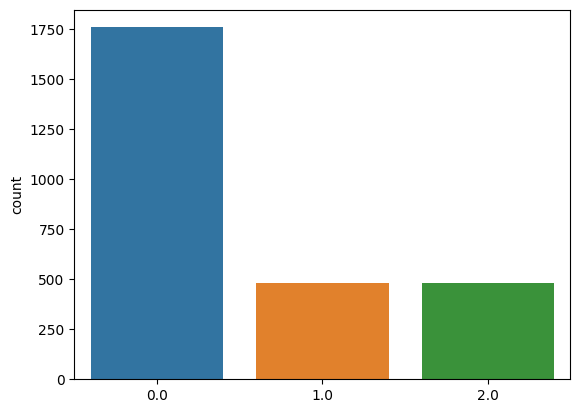

In [ ]:
sns.countplot(x = y_test.ravel())

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=200, weights='uniform', algorithm='kd_tree', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=1)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))

#------------------------------------------------------------------
#--- How should I compare my accuracy ?

# Random Model, gambler?
pred_test = np.random.choice([0, 1, 2], len(y_pred_test))
accuracy_test = accuracy_score(y_test, pred_test)
print("Accuracy Gambler: %.2f%%" % (accuracy_test * 100.0))

Accuracy train: 60.81%
Accuracy test: 64.66%
Accuracy Gambler: 33.65%


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         0.0       0.66      0.33      0.44      1760
         1.0       0.19      0.36      0.25       479
         2.0       0.18      0.35      0.24       483

    accuracy                           0.34      2722
   macro avg       0.34      0.34      0.31      2722
weighted avg       0.49      0.34      0.37      2722



<Axes: ylabel='count'>

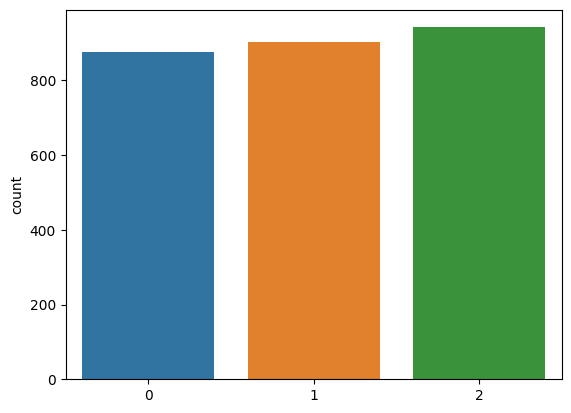

In [ ]:
sns.countplot(x = pred_test.ravel())

In [ ]:
X_all

open   close    high     low         value     volume  \
43    302.18  301.24  302.35  301.22  7.226691e+08  2395950.0   
44    301.22  298.32  301.35  298.30  2.348388e+09  7830270.0   
45    298.32  299.77  299.92  298.20  7.577354e+08  2532790.0   
46    299.79  299.60  300.19  299.13  5.417489e+08  1807380.0   
47    299.59  298.77  299.76  298.00  1.389502e+09  4650000.0   
...      ...     ...     ...     ...           ...        ...   
6511  276.01  274.88  276.63  274.50  1.158084e+09  4206840.0   
6512  274.88  274.99  275.48  274.70  4.064831e+08  1477790.0   
6513  275.01  274.77  275.25  273.55  1.195028e+09  4356630.0   
6514  274.74  275.09  276.00  274.25  7.096614e+08  2578960.0   
6515  275.16  274.14  275.16  274.00  2.649524e+08   965560.0   

                   begin                 end       ATR        RSI  Average  \
43   2022-01-05 13:00:00 2022-01-05 13:59:59  1.675162  40.596000  301.785   
44   2022-01-05 14:00:00 2022-01-05 14:59:59  1.777282  31.670354  299.825   
45   2022-01-05 15:00:00 2022-01-05 15:59:59  1.773039  38.859173  299.060   
46   2022-01-05 16:00:00 2022-01-05 16:59:59  1.720365  38.349752  299.660   
47   2022-01-05 17:00:00 2022-01-05 17:59:59  1.723286  35.876828  298.880   
...                  ...                 ...       ...        ...      ...   
6511 2023-12-01 15:00:00 2023-12-01 15:59:59  1.423352  40.965939  275.565   
6512 2023-12-01 16:00:00 2023-12-01 16:59:59  1.377399  41.583967  275.090   
6513 2023-12-01 17:00:00 2023-12-01 17:59:59  1.400442  40.666982  274.400   
6514 2023-12-01 18:00:00 2023-12-01 18:59:59  1.425410  42.648037  275.125   
6515 2023-12-01 19:00:00 2023-12-01 19:59:59  1.406452  38.534563  274.580   

         MA40      MA80      MA160  slopeMA40  slopeMA80  slopeMA160  \
43    302.873  303.8255  303.81000    -0.2233   -0.22760    0.156175   
44    302.250  303.4620  303.76175    -0.3190   -0.22175    0.102450   
45    301.803  303.1505  303.72975    -0.4030   -0.23705    0.042225   
46    301.391  302.8865  303.69475    -0.4568   -0.27290   -0.007875   
47    301.029  302.6235  303.60900    -0.4547   -0.29795   -0.046900   
...       ...       ...        ...        ...        ...         ...   
6511  276.727  276.1400  276.97200    -0.0048   -0.00530   -0.097425   
6512  276.436  276.1250  276.84925    -0.1401   -0.00615   -0.111350   
6513  276.146  276.1180  276.72875    -0.2283   -0.01010   -0.123475   
6514  275.905  276.0660  276.60825    -0.2673   -0.01520   -0.125175   
6515  275.619  275.9990  276.47775    -0.2747   -0.03410   -0.122950   

      AverageSlope  RSISlope  
43         -0.1600 -1.732142  
44         -0.7380 -4.000652  
45         -0.9835 -2.255920  
46         -0.7865 -1.395972  
47         -0.5975 -0.275895  
...            ...       ...  
6511       -0.1455 -2.145353  
6512       -0.5120 -2.630506  
6513       -0.7485 -2.554402  
6514       -0.4285 -0.613146  
6515       -0.1935 -0.379868  

[6473 rows x 19 columns]

In [ ]:
import random

In [ ]:
def rebuild(data):
    array_data = data.copy()
    repeat_val = array_data[0]
    for i in range(len(array_data) - 1):
        if repeat_val == 1:
            if repeat_val == array_data[i + 1]:
                array_data[i + 1] = 0
            else:
                repeat_val = array_data[i + 1]
        elif repeat_val == 2:
            array_data[i] = 0
            if repeat_val == array_data[i + 1]:
                array_data[i + 1] = 0
            elif array_data[i + 1] != repeat_val:
                array_data[i] = 2
                repeat_val = array_data[i + 1]
        elif repeat_val == 0:
            repeat_val = array_data[i + 1]
    return array_data

def backtest(X_all, cash=100_000):
    balance = cash
    amount_paper = 0
    last_price = 0
    arr_balance= []
    trades = []
    commision = 0.0005
    X_all = X_all[train_index:]

    for i in range(len(X_test)):
        a = [pred_test[i], X_all['indicator_rsi'].iloc[i], X_all.iloc[i]['indicator_alligator']]
        if sorted(a)[0] == sorted(a)[1] == 0:
            predict = 0
        else:
            predict = max(X_all['indicator_rsi'].iloc[i], X_all.iloc[i]['indicator_alligator'])
        if predict == 1 and amount_paper != 0:
            balance += amount_paper * X_all.iloc[i]['close']
            balance -= amount_paper * commision * X_all.iloc[i]['close']
            amount_paper = 0
            trades.append([data.iloc[i].begin,  X_all.iloc[i]['close'], 0])
        if predict == 2:
            buy = balance // (X_all.iloc[i]['close'] * (1 + commision))
            amount_paper += buy
            balance -= buy * X_all.iloc[i]['close']
            balance -= buy * commision * X_all.iloc[i]['close']
            if buy > 0:
                trades.append([X_all.iloc[i].begin,  X_all.iloc[i]['close'], 1])
        arr_balance.append(amount_paper * X_all.iloc[i]["close"] + balance)
    trades = np.array(trades)
    return arr_balance, trades

cap, tr = backtest(X_all)

In [ ]:
rebuild(pred_test)

array([0, 0, 2, ..., 1, 0, 0])

In [ ]:
pred_test

array([0, 0, 2, ..., 1, 1, 1])

In [ ]:
count = 100_000 / X_all[train_index:].iloc[0].close
count

479.2715073088905

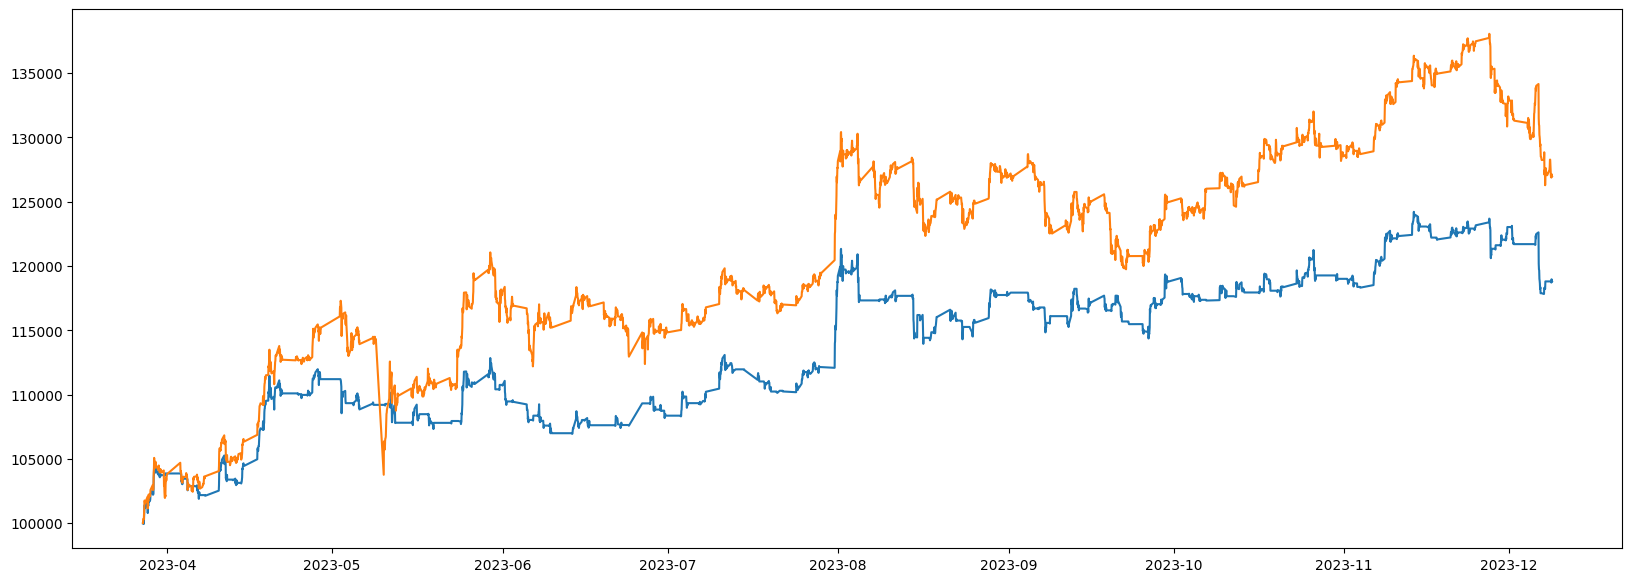

In [ ]:
plt.figure(figsize=(20, 7))
plt.plot(X_all[train_index:].begin, cap)
plt.plot(X_all[train_index:].begin, count * X_all[train_index:].close)

In [ ]:
 !pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.2 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(learning_rate=0.001, loss_function='MultiClass', eval_metric='Accuracy')
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

0:	learn: 0.4268689	total: 58.4ms	remaining: 58.3s
1:	learn: 0.4449260	total: 73ms	remaining: 36.4s
2:	learn: 0.4550379	total: 88ms	remaining: 29.2s
3:	learn: 0.4557602	total: 103ms	remaining: 25.6s
4:	learn: 0.4532322	total: 117ms	remaining: 23.3s
5:	learn: 0.4525099	total: 134ms	remaining: 22.2s
6:	learn: 0.4532322	total: 143ms	remaining: 20.3s
7:	learn: 0.4543156	total: 151ms	remaining: 18.7s
8:	learn: 0.4535934	total: 159ms	remaining: 17.5s
9:	learn: 0.4543156	total: 172ms	remaining: 17.1s
10:	learn: 0.4532322	total: 188ms	remaining: 16.9s
11:	learn: 0.4561213	total: 198ms	remaining: 16.3s
12:	learn: 0.4546768	total: 206ms	remaining: 15.7s
13:	learn: 0.4564825	total: 214ms	remaining: 15.1s
14:	learn: 0.4582882	total: 223ms	remaining: 14.6s
15:	learn: 0.4572048	total: 230ms	remaining: 14.2s
16:	learn: 0.4561213	total: 240ms	remaining: 13.9s
17:	learn: 0.4615385	total: 248ms	remaining: 13.5s
18:	learn: 0.4633442	total: 256ms	remaining: 13.2s
19:	learn: 0.4633442	total: 269ms	remainin

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.43      0.74      0.54       289
           1       0.35      0.25      0.29       197
           2       0.35      0.08      0.13       207

    accuracy                           0.41       693
   macro avg       0.37      0.36      0.32       693
weighted avg       0.38      0.41      0.35       693



<Axes: ylabel='count'>

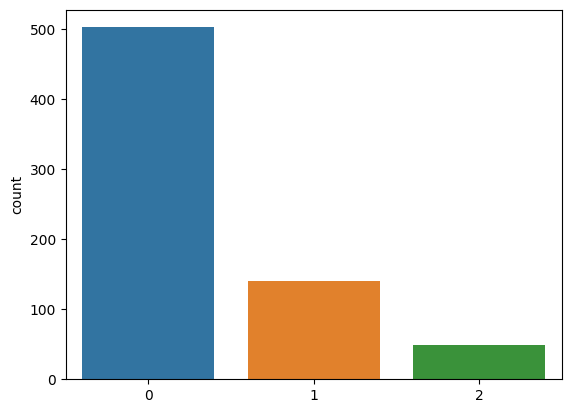

In [ ]:
sns.countplot(x = pred_test.ravel())

In [ ]:
from matplotlib import pyplot
from xgboost import plot_importance
#plot feature importance
plot_importance(model)
pyplot.show()

ValueError: ignored

In [ ]:
def trading(model, X_test, X_all):
  x_test = X_test
  returns = pd.DataFrame()
  statement = 0 #  {0:in_cash, 1:long, 2:short}
  stock = 0.   # Число акций
  cash = 1_000_000.   # Стартовая сумма капитала
  # -----------------------------------------

  for i in range(len(X_test)):   # Выбираю пример
    x = [X_test.iloc[i]]
    # x = np.expand_dims(x, axis=0)
    # x = np.array(x)
    prediction = model.predict(x)[0][0] - 1 # Распознаём наш пример  == {0:stay, 1:up, 2:down}
    print(prediction)
    signal = prediction # Получаем индекс самого большого элемента (это итоговая цифра)
    #close = xScaler.inverse_transform(x_test[i])[-3][0] # опрелеяем текущую цену, подаваемую в нейронку
    close = X_all['close'][i]
    #close = close[-1][3]
    # close = close[-1][0]
    line = pd.DataFrame({'statement':[0], 'signal':[signal], 'close':[close],'stock':[0], 'deal_prise':[close],
                'long':[close*0.9], 'short':[0], 'inv_capital':[0], 'cash':[cash],
                'capital':[0], 'ret(i)':[0] })
    returns = returns.append(line, ignore_index=True)

    if statement == 0  and  signal == 1:## ok
      statement = 1
      capital = cash//close * close + cash - cash//close * close
      inv_capital = cash//close * close
      line = pd.DataFrame({'statement':[0], 'signal':[signal], 'close':[close],'stock':[cash//close], 'deal_prise':[close],
                           'long':[close*0.9], 'short':[0], 'inv_capital':[inv_capital], 'cash':[cash - cash//close * close],
                           'capital':[capital], 'ret(i)':[0] })
      returns = returns.append(line, ignore_index=True)
      continue

    elif statement == 0  and  signal == 0:## ok
      line = pd.DataFrame({'statement':[statement], 'signal':[signal], 'close':[close],'stock':[0],  'deal_prise':[0],
                           'long':[0], 'short':[0], 'inv_capital':[0], 'cash':[cash], 'capital':[cash], 'ret(i)':[0] })
      returns = returns.append(line, ignore_index=True)
      continue

    elif statement == 1  and  signal == 1:## ok
      stock = returns.iloc[i-1][3]
      cash = returns.iloc[i-1][8]
      inv_capital = close*stock
      capital = close*stock+cash
      line = pd.DataFrame({'statement':[statement], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[returns.iloc[i-1][4]],
                           'long':[0], 'short':[0], 'inv_capital':[inv_capital], 'cash':[cash],  'capital':[capital], 'ret(i)':[0] })
      returns = returns.append(line, ignore_index=True)
      continue

    elif statement == 1  and  signal == 0:## выходим в кэш!
      statement = 0
      stock = returns.iloc[i-1][3]
      ret = (close - returns.iloc[i-1][4]) * stock
      capital = close * stock + returns.iloc[i-1][8]
      stock = 0
      inv_capital = close*stock
      cash = capital - inv_capital
      line = pd.DataFrame({'statement':[1], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[close],
                           'long':[0], 'short':[close*1.1], 'inv_capital':[inv_capital], 'cash':[cash], 'capital':[capital], 'ret(i)':[ret] })
      returns = returns.append(line, ignore_index=True)
      continue

  return returns

returns = trading(model, X_test, X_all)

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
1
1
1
1
1
1
1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
1
1
1
1
1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
1
1
1
1
1
1
1
-1
-1
1
1
1
1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
1
-1
1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed fr

1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
1
1
1
1
1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
1
1
1
1
1
1
1
1
1
1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
1
1
1
-1
-1
-1
1
1
1
1
1
1
1
1

<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr


1
1
1
1
1
1
1
1
1
1
1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
1
1
1
1
1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
1
1
1
1
1
1
1
1
1
1


<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed fr

1
0
0
0
0
0
0
0
0
0
0
0
0
0
0


<ipython-input-270-789a99fb1877>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:38: FutureWarning: The frame.append method is deprecated and will be removed fr

0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
1
1
1
1
1
-1
-1
1
1
-1
1
1
1
1
1


<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
1
1
0
0
1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
1
1
1
1
-1
-1


<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
1
1
-1
1
1
1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
1
1
1
1
1
1
1
1
1
1
1
-1
-1
-1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
1
1
1
1
1
-1
1
1


<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
1
1
1
1
1
1
1
1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
-1
-1
-1
-1
-1
1
1
1
1
1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
-1
-1
-1
-1
-1
-1
1
1
1
1
-1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
1
-1
-1
-1
-1
-1
-1
-1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
1
1
1
1
1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
1
1
1
1
1

<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed fr


1
1
1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1

<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr


-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
1
-1
1
1
1
1
1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
1
1
1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
1
-1
-1
-1
-1
-1
-1
1
1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

0
0
0
0
-1
-1
-1
0
0
1
1
1
1
1
1
1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0


<ipython-input-270-789a99fb1877>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:38: FutureWarning: The frame.append method is deprecated and will be removed fr

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


<ipython-input-270-789a99fb1877>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:38: FutureWarning: The frame.append method is deprecated and will be removed fr

0
0
0
0
0
0
0
0
1
1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
1
1
1
1
1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
0
0
0
0


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

0
0
0
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
1
-1
-1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
-1
-1
1
1
1
1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
1
1
1
1
1
1
1
1
1
1
-1
-1
-1
-1
1
1
1
1
1
1
1
1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
1
1
-1
-1
-1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
1
1
1
1
1
1
1
1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
1
1
1
1
-1
-1
-1
-1
-1
1
1
1
1
-1
-1
-1
-1
1
1
1
1
-1
-1
-1
1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
-1
-1
-1
-1
-1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
-1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
1
1
1
1
1
1
1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
1
1
1
1
-1
1
1
1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
1
1
1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
1
1
-1
-1
1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
1
1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
1
1
1
1
1
1
1
1
1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

1
1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
1
1
-1
-1
-1
1
1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

-1
-1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
-1
1
1
1

<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr


-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns = returns.append(line, ignore_index=True)
<ipython-input-270-789a99fb1877>:23: FutureWarning: The frame.append method is deprecated and will be removed fr

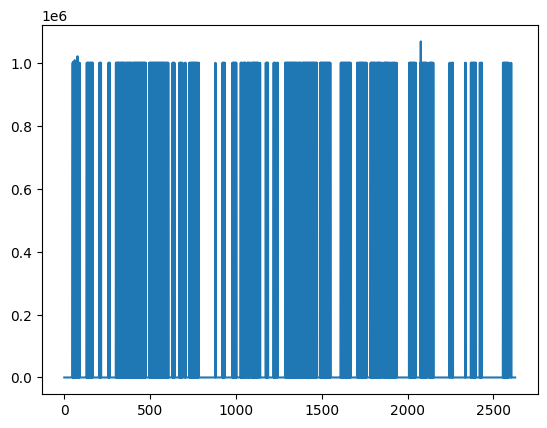

In [ ]:
plt.plot(returns.capital)

# **2 try**

In [ ]:
WINDOW = 14
STEP = 1
FORECAST = 1
PLATO_LVL = 0.0

In [ ]:
sber = Ticker('SBER')
sber_data = sber.candles(date='2020-01-01', till_date='2023-12-01', period='1h')
print(f'strat: {sber_data.begin.min()}\
        \nend: {sber_data.begin.max()}\
        \ncount: {sber_data.shape[0]}')
ST = sber_data.begin[sber_data.begin.argmax() - WINDOW - 1]
sber_data.drop(['open', 'high',	'low', 	'value', 'volume', 'begin', 'end'], axis=1, inplace=True)

strat: 2020-01-03 09:00:00        
end: 2022-12-26 16:00:00        
count: 10000


In [ ]:
sber_data['next'] = np.concatenate([sber_data.close.values[FORECAST:], [np.nan for i in range(FORECAST)]])

In [ ]:
for i in range(1, WINDOW + 1):
  indicator_name = 'Close_chng_%d' % (i)
#   indicator_name_new = 'Y_%d' % (i)
#   sber_data[indicator_name_new] = 0
  sber_data[indicator_name] = sber_data['close'].pct_change(i)
#   sber_data.loc[sber_data[indicator_name] > (PLATO_LVL), indicator_name_new] = 1
sber_data = sber_data.dropna()
sber_data = sber_data.reset_index(drop=True)
sber_data.head()


close    next  Close_chng_1  Close_chng_2  Close_chng_3  Close_chng_4  \
0  251.84  252.01      0.000516     -0.000833     -0.001031     -0.011423   
1  252.01  252.17      0.000675      0.001192     -0.000159     -0.000357   
2  252.17  252.46      0.000635      0.001310      0.001827      0.000476   
3  252.46  252.49      0.001150      0.001786      0.002462      0.002980   
4  252.49  253.90      0.000119      0.001269      0.001905      0.002581   

   Close_chng_5  Close_chng_6  Close_chng_7  Close_chng_8  Close_chng_9  \
0     -0.012392     -0.009868     -0.010452     -0.012276     -0.011035   
1     -0.010756     -0.011725     -0.009200     -0.009784     -0.011609   
2      0.000278     -0.010128     -0.011098     -0.008571     -0.009155   
3      0.001627      0.001428     -0.008989     -0.009961     -0.007431   
4      0.003099      0.001746      0.001547     -0.008871     -0.009843   

   Close_chng_10  Close_chng_11  Close_chng_12  Close_chng_13  Close_chng_14  
0      -0.017976      -0.020840      -0.020116      -0.015365      -0.016212  
1      -0.010367      -0.017313      -0.020179      -0.019454      -0.014701  
2      -0.010982      -0.009739      -0.016689      -0.019557      -0.018832  
3      -0.008016      -0.009844      -0.008600      -0.015559      -0.018429  
4      -0.007313      -0.007898      -0.009727      -0.008482      -0.015442

In [ ]:
# Маркируем направление движения
indicator_name = 'Close_chng_%d' % (1)

def check_trend(x):
    if x['close'] < x['next']:
        return 1
    return 0

sber_data['Y'] = sber_data.apply(lambda x: check_trend(x), axis=1)
sber_data.drop(['next'], axis=1, inplace=True)

In [ ]:
sber_data.head()

close  Close_chng_1  Close_chng_2  Close_chng_3  Close_chng_4  \
0  251.84      0.000516     -0.000833     -0.001031     -0.011423   
1  252.01      0.000675      0.001192     -0.000159     -0.000357   
2  252.17      0.000635      0.001310      0.001827      0.000476   
3  252.46      0.001150      0.001786      0.002462      0.002980   
4  252.49      0.000119      0.001269      0.001905      0.002581   

   Close_chng_5  Close_chng_6  Close_chng_7  Close_chng_8  Close_chng_9  \
0     -0.012392     -0.009868     -0.010452     -0.012276     -0.011035   
1     -0.010756     -0.011725     -0.009200     -0.009784     -0.011609   
2      0.000278     -0.010128     -0.011098     -0.008571     -0.009155   
3      0.001627      0.001428     -0.008989     -0.009961     -0.007431   
4      0.003099      0.001746      0.001547     -0.008871     -0.009843   

   Close_chng_10  Close_chng_11  Close_chng_12  Close_chng_13  Close_chng_14  \
0      -0.017976      -0.020840      -0.020116      -0.015365      -0.016212   
1      -0.010367      -0.017313      -0.020179      -0.019454      -0.014701   
2      -0.010982      -0.009739      -0.016689      -0.019557      -0.018832   
3      -0.008016      -0.009844      -0.008600      -0.015559      -0.018429   
4      -0.007313      -0.007898      -0.009727      -0.008482      -0.015442   

   Y  
0  1  
1  1  
2  1  
3  1  
4  1

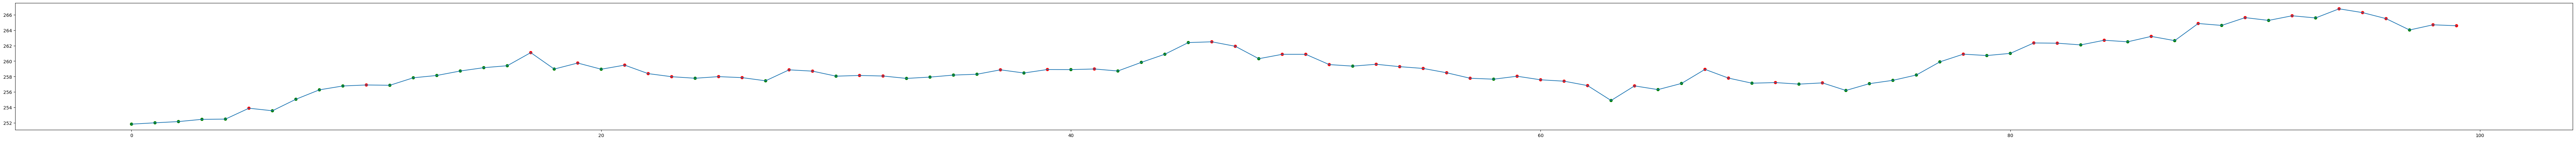

In [ ]:
colors = ['red', 'green']
count=100
plt.figure(figsize=(100, 5))
plt.plot(sber_data.close[:count])
plt.scatter(sber_data.index[:count], sber_data.close[:count], c=[colors[int(i)] for i in sber_data['Y'][:count]])

In [ ]:
X = np.array(sber_data.drop('Y', axis=1))
y = sber_data['Y'].map(lambda x : [0., 1.] if x else [1., 0.]).values
y = np.array([[arr[0], arr[1]] for arr in y])

In [ ]:

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

def create_Xt_Yt(X, y, percentage=0.9):
    # p = int(len(X) * percentage)
    p = 600
    # X_train = X[0:p]
    # Y_train = y[0:p]
    X_train = X[:-p]
    Y_train = y[:-p]

    # X_train, Y_train = shuffle_in_unison(X_train, Y_train)

    # X_test = X[p:]
    # Y_test = y[p:]
    X_test = X[-p:]
    Y_test = y[-p:]
    return X_train, X_test, Y_train, Y_test

X_train, X_test, y_train, y_test = create_Xt_Yt(X, y)

xScaler = RobustScaler()
xScaler.fit(X_train)
X_train = xScaler.transform(X_train)
X_test = xScaler.transform(X_test)

device = "cuda" if torch.cuda.is_available() else "cpu"
X_train = torch.from_numpy(X_train).to(torch.float32).to(device)
X_test = torch.from_numpy(X_test).to(torch.float32).to(device)
y_train = torch.from_numpy(y_train).to(torch.float32).to(device)
y_test = torch.from_numpy(y_test).to(torch.float32).to(device)

In [ ]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=True)
loaders = {"train": train_dataloader, "valid": test_dataloader}

# **1 try**
### https://blog.sf.education/tutorial-nejroseti-dlya-algoritmicheskoj-torgovli/

In [ ]:
def make_x_y(data):
    data = data['open'].copy()
    data = data.pct_change().to_list()
    plt.plot(data)

    X, Y = [], []
    for i in range(WINDOW, len(data), STEP):
        x_i = data[i-WINDOW:i]
        y_i = data[i-1+FORECAST]
        last_close = x_i[-1]
        next_close = y_i
        if next_close >= 0:
            y_i = [0, 1]
        else:
            y_i = [1, 0]

        X.append(x_i)
        Y.append(y_i)

    X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X]
    return np.array(X)[1:, :], np.array(Y)[1:, :],

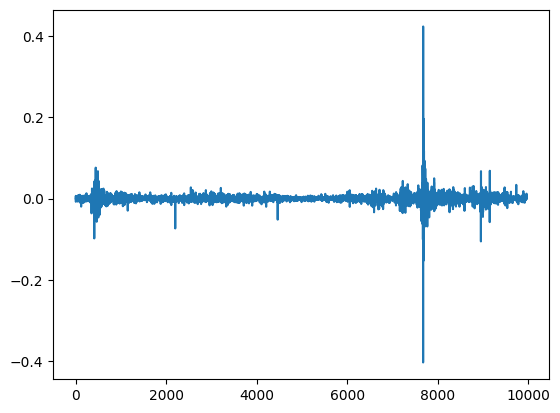

In [ ]:
X, y = make_x_y(sber_data)

In [ ]:
X, y

(array([[-0.16503884, -0.37406577,  1.36072657, ...,  0.27452023,
          0.46899659,  0.6989607 ],
        [-0.37535753,  1.35974767,  0.10327118, ...,  0.46785688,
          0.69786245, -0.12956401],
        [ 1.21899124,  0.02613426, -1.07787958, ...,  0.59061943,
         -0.19491172,  1.72897894],
        ...,
        [-0.21997338, -1.93321589,  0.49314513, ..., -0.53892421,
          3.90432142,  1.30910239],
        [-1.94695357,  0.48043292, -0.87202902, ...,  3.8930509 ,
          1.29673503,  0.15463199],
        [ 0.45748679, -0.98782686, -0.46322345, ...,  1.32983117,
          0.10931837, -0.45865809]]),
 array([[0, 1],
        [0, 1],
        [1, 0],
        ...,
        [0, 1],
        [1, 0],
        [0, 1]]))

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

X = torch.from_numpy(X).to(torch.float32).to(device)
y = torch.from_numpy(y).to(torch.float32).to(device)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)
loaders = {"train": train_dataloader, "valid": test_dataloader}

cuda


TypeError: ignored

# **end**

In [ ]:
# model = nn.Sequential(
#     nn.Linear(30, 64),
#     nn.BatchNorm1d(64),
#     nn.LeakyReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(64, 16),
#     nn.BatchNorm1d(16),
#     nn.LeakyReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(16, 2),
#     nn.Softmax(dim=1)
# )
def accuracy(output, target):
    _, pred = torch.max(output, 1)
    target_indices = torch.max(target, 1)[1]
    correct = pred.eq(target_indices).sum()
    accuracy = correct.float() / target.size(0)
    return accuracy

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(15, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 16)
        self.bn2 = nn.BatchNorm1d(16)
        self.fc3 = nn.Linear(16, 2)

    def predict(self, x_test):
        self.eval()
        with torch.no_grad():
            pred = self(x_test)
        return pred

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.leaky_relu(self.bn2(self.fc2(x)))
        x = F.softmax(self.fc3(x), dim=1)
        return x

class LSTMModel(nn.Module):
    def __init__(self, input_dim):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, input_dim, batch_first=True)
        self.lstm2 = nn.LSTM(input_dim, input_dim, batch_first=True)
        self.fc = nn.Linear(input_dim, 1)

    def predict(self, x_test):
        self.eval()
        with torch.no_grad():
            pred = self(x_test)
        return pred

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = F.softmax(self.fc(x), dim=1)
        return x

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=150):
    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = {'train': [], 'val': []}
        epoch_acc = {'train': [], 'val': []}
        for k, dataloader in loaders.items():
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    epoch_loss['train'].append(loss.detach().flatten()[0])
                    optimizer.step()
                    acc = accuracy(outp, y_batch)
                    epoch_acc['train'].append(acc)
                    scheduler.step(acc)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    epoch_loss['val'].append(loss.detach().flatten()[0])
                    acc = accuracy(outp, y_batch)
                    epoch_acc['val'].append(acc)
        losses['train'].append(sum(epoch_loss['train']) / len(epoch_loss['train']))
        losses['val'].append(sum(epoch_loss['val']) / len(epoch_loss['val']))
        accuracies['train'].append(sum(epoch_acc['train']) / len(epoch_acc['train']))
        accuracies['val'].append(sum(epoch_acc['val']) / len(epoch_acc['val']))
    return model, losses, accuracies

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# model = Net().to(device)
model = LSTMModel(X_train.shape[1]).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=0.01, weight_decay=1e-2)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=25, min_lr=0.000001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model, losses, accuracies = train_model(model, criterion, optimizer, scheduler, num_epochs=150)

  0%|          | 0/150 [00:00<?, ?it/s]


NameError: ignored

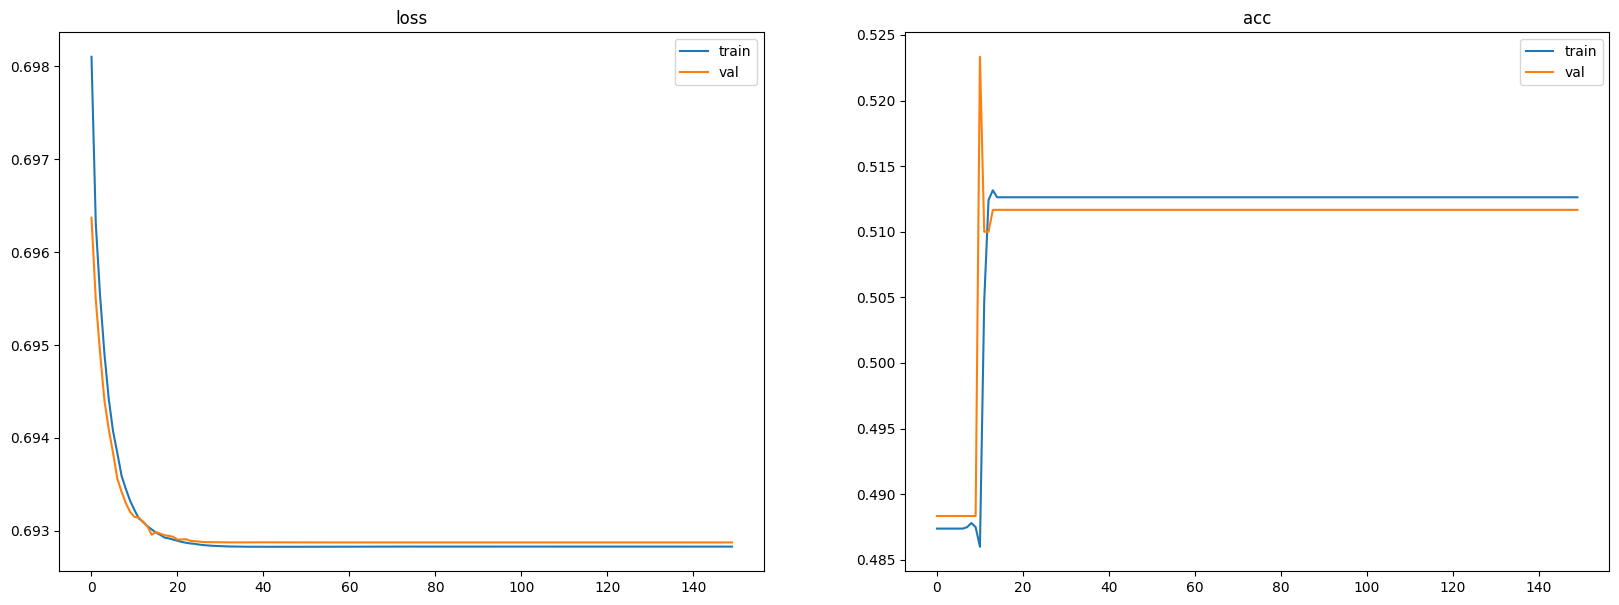

In [ ]:
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.title('loss')
plt.plot(torch.tensor(losses['train']).to('cpu'), label='train')
plt.plot(torch.tensor(losses['val']).to('cpu'), label='val')
plt.legend()
plt.subplot(122)
plt.title('acc')
plt.plot(torch.tensor(accuracies['train']).to('cpu'), label='train')
plt.plot(torch.tensor(accuracies['val']).to('cpu'), label='val')
plt.legend()

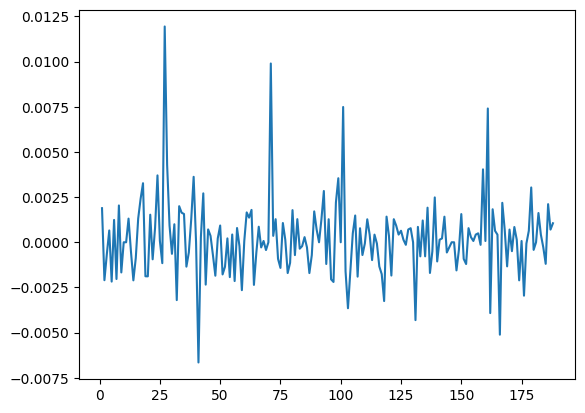

In [ ]:
# test_data = sber.candles(date=ST, till_date='2023-01-10', period='1h')
# X_test, y_test = make_x_y(test_data)

In [ ]:
pred =  model.predict((X_test))
accuracy(pred, y_test)

tensor(0.5117, device='cuda:0')

In [ ]:
def trading(model, xTest):
  x_test = xTest
  returns = pd.DataFrame()
  statement = 0 #  {0:in_cash, 1:long, 2:short}
  stock = 0.   # Число акций
  cash = 1_000_000.   # Стартовая сумма капитала
  # -----------------------------------------

  for i in range(len(x_test)):   # Выбираю пример
    x = x_test[i].to('cpu')
    x = np.expand_dims(x, axis=0)
    x = torch.from_numpy(np.array(x)).to(torch.float32).to(device)
    prediction = model.predict(x).to('cpu').numpy() # Распознаём наш пример  == {0:stay, 1:up, 2:down}
    signal = np.argmax(prediction) # Получаем индекс самого большого элемента (это итоговая цифра)
    #close = xScaler.inverse_transform(x_test[i])[-3][0] # опрелеяем текущую цену, подаваемую в нейронку
    close = xScaler.inverse_transform(np.array([x_test[i].to('cpu').numpy()]))
    #close = close[-1][3]
    close = close[-1][0]

    if statement == 0  and  signal == 1:## ok
      statement = 1
      capital = cash//close * close + cash - cash//close * close
      inv_capital = cash//close * close
      line = pd.DataFrame({'statement':[0], 'signal':[signal], 'close':[close],'stock':[cash//close], 'deal_prise':[close],
                           'long':[close*0.9], 'short':[0], 'inv_capital':[inv_capital], 'cash':[cash - cash//close * close],
                           'capital':[capital], 'ret(i)':[0] })
      returns = returns.append(line, ignore_index=True)
      continue

    elif statement == 0  and  signal == 0:## ok
      line = pd.DataFrame({'statement':[statement], 'signal':[signal], 'close':[close],'stock':[0],  'deal_prise':[0],
                           'long':[0], 'short':[0], 'inv_capital':[0], 'cash':[cash], 'capital':[cash], 'ret(i)':[0] })
      returns = returns.append(line, ignore_index=True)
      continue

    elif statement == 1  and  signal == 1:## ok
      stock = returns.iloc[i-1][3]
      cash = returns.iloc[i-1][8]
      inv_capital = close*stock
      capital = close*stock+cash
      line = pd.DataFrame({'statement':[statement], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[returns.iloc[i-1][4]],
                           'long':[0], 'short':[0], 'inv_capital':[inv_capital], 'cash':[cash],  'capital':[capital], 'ret(i)':[0] })
      returns = returns.append(line, ignore_index=True)
      continue

    elif statement == 1  and  signal == 0:## выходим в кэш!
      statement = 0
      stock = returns.iloc[i-1][3]
      ret = (close - returns.iloc[i-1][4]) * stock
      capital = close * stock + returns.iloc[i-1][8]
      stock = 0
      inv_capital = close*stock
      cash = capital - inv_capital
      line = pd.DataFrame({'statement':[1], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[close],
                           'long':[0], 'short':[close*1.1], 'inv_capital':[inv_capital], 'cash':[cash], 'capital':[capital], 'ret(i)':[ret] })
      returns = returns.append(line, ignore_index=True)
      continue

  return returns

def plotting(returns):
  short = returns['short'].values
  short = short.astype(bool)
  long = returns['long'].values
  long = long.astype(bool)
  idx_long = np.where(long)
  idx_short = np.where(short)

  plt.figure(figsize=(200,5))

  plt.subplot(121)
  plt.plot(returns['close'], alpha=0.6)
  plt.plot(idx_long[0], returns['close'].values[[idx_long]][0][0], '^', c='g')
  plt.plot(idx_short[0], returns['close'].values[[idx_short]][0][0], 'v', c='r', fillstyle='none')
  plt.grid()

  plt.subplot(122)
  plt.plot(returns['capital'])
  plt.grid()
  plt.show()

In [ ]:
returns = trading(model, X_test[:600])
returns

KeyError: ignored

<Axes: >

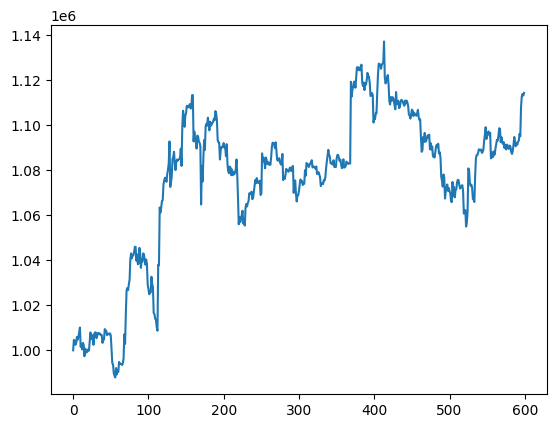

In [ ]:
returns.capital.plot()

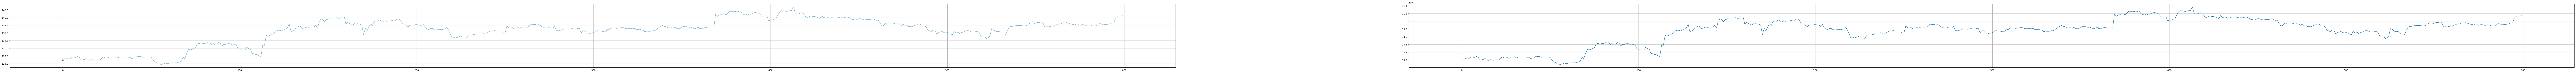

In [ ]:
plotting(returns)

In [ ]:
pred = pred.to('cpu').numpy()
pred = np.where(pred >= 0.5, 1, 0)

In [ ]:
pred

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [ ]:
pd.DataFrame({'pred': pred[:, 1], 'test': y_test.to('cpu')[:, 1]})

pred  test
0       1   1.0
1       1   0.0
2       1   0.0
3       1   1.0
4       1   1.0
..    ...   ...
595     1   1.0
596     1   1.0
597     1   0.0
598     1   1.0
599     1   0.0

[600 rows x 2 columns]

In [ ]:
sber_data

close  Y  Close_chng_1  Close_chng_2  Close_chng_3  Close_chng_4  \
0     251.84  1      0.000516     -0.000833     -0.001031     -0.011423   
1     252.01  1      0.000675      0.001192     -0.000159     -0.000357   
2     252.17  1      0.000635      0.001310      0.001827      0.000476   
3     252.46  1      0.001150      0.001786      0.002462      0.002980   
4     252.49  1      0.000119      0.001269      0.001905      0.002581   
...      ... ..           ...           ...           ...           ...   
9980  139.83  1      0.011868      0.010844      0.013702      0.014069   
9981  140.43  1      0.004291      0.016210      0.015181      0.018051   
9982  140.56  0      0.000926      0.005221      0.017150      0.016121   
9983  140.47  1     -0.000640      0.000285      0.004577      0.016499   
9984  140.62  0      0.001068      0.000427      0.001353      0.005650   

      Close_chng_5  Close_chng_6  Close_chng_7  Close_chng_8  Close_chng_9  \
0        -0.012392     -0.009868     -0.010452     -0.012276     -0.011035   
1        -0.010756     -0.011725     -0.009200     -0.009784     -0.011609   
2         0.000278     -0.010128     -0.011098     -0.008571     -0.009155   
3         0.001627      0.001428     -0.008989     -0.009961     -0.007431   
4         0.003099      0.001746      0.001547     -0.008871     -0.009843   
...            ...           ...           ...           ...           ...   
9980      0.015321      0.014584      0.015985      0.014069      0.012161   
9981      0.018420      0.019678      0.018938      0.020344      0.018420   
9982      0.018994      0.019363      0.020622      0.019881      0.021289   
9983      0.015470      0.018341      0.018711      0.019968      0.019228   
9984      0.017584      0.016555      0.019429      0.019798      0.021057   

      Close_chng_10  Close_chng_11  Close_chng_12  Close_chng_13  \
0         -0.017976      -0.020840      -0.020116      -0.015365   
1         -0.010367      -0.017313      -0.020179      -0.019454   
2         -0.010982      -0.009739      -0.016689      -0.019557   
3         -0.008016      -0.009844      -0.008600      -0.015559   
4         -0.007313      -0.007898      -0.009727      -0.008482   
...             ...            ...            ...            ...   
9980       0.015395       0.017908       0.019169       0.018427   
9981       0.016504       0.019752       0.022276       0.023542   
9982       0.019363       0.017445       0.020696       0.023222   
9983       0.020635       0.018711       0.016793       0.020042   
9984       0.020316       0.021725       0.019798       0.017879   

      Close_chng_14  
0         -0.016212  
1         -0.014701  
2         -0.018832  
3         -0.018429  
4         -0.015442  
...             ...  
9980       0.016206  
9981       0.022797  
9982       0.024490  
9983       0.022567  
9984       0.021131  

[9985 rows x 16 columns]

In [ ]:
x = xScaler.inverse_transform(X_test.to('cpu').numpy())[:, 0].ravel()
y_test

tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [0., 1.],
        [1., 0.]], device='cuda:0')

<Figure size 5000x700 with 0 Axes>

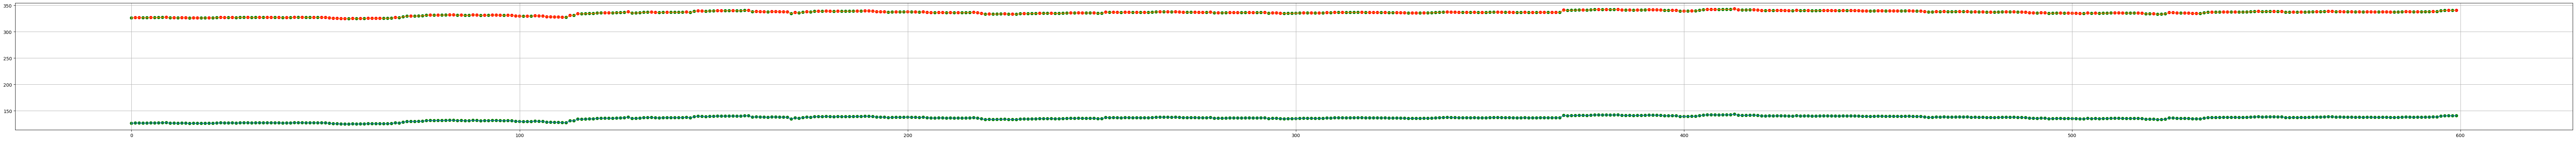

In [ ]:
plt.figure(figsize=(50, 7))
y = x
x = np.array([i for i in range(len(x))])

colors= ['red', 'green']
plt.figure(figsize=(100, 5))
plt.plot(x, y)
plt.scatter(x, y, c=[colors[i] for i in pred[:, 1]])
plt.plot(x, y+200)
plt.scatter(x, y+200, c=[colors[int(i)] for i in y_test.to('cpu').numpy()[:, 1]])
plt.grid()

In [ ]:
def binary_accuracy(output, target):
    pred = (output >= 0.5).float()
    correct = (pred == target).float().sum()
    print(correct)
    accuracy = correct / target.size(0)
    return accuracy

out = torch.tensor([[0.6, 0.4], [0.2, 0.8], [0.1, 0.9]])
tar = torch.tensor([[1., 0.], [0., 1.], [0., 1.]])
binary_accuracy(out, tar)

tensor(6.)


tensor(2.)

In [ ]:
!pip install backtesting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173916 sha256=dc1e6f8e40b8247db2cc25d00e4ba38bc3f938951dcd274a35e02018c85b10da
  Stored in directory: /root/.cache/pip/wheels/e2/30/7f/19cbe31987c6ebdb47f1f510343249066711609e3da2d57176
Successfully built backtesting


In [ ]:
from backtesting import Backtest, Strategy, set_bokeh_output
from backtesting.lib import crossover
from backtesting.test import SMA, GOOG

set_bokeh_output(notebook=False)

class SmaCross(Strategy):
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, 10)
        self.ma2 = self.I(SMA, price, 20)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()


bt = Backtest(GOOG, SmaCross, commission=.002,
              exclusive_orders=True)
stats = bt.run()
bt.plot()


/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p1990', ...)